# Item2Vec




# 0. Import Packages

In [222]:
import numpy as np
import pandas as pd
import keras as K
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Flatten, merge, Reshape, Dot, Add, Concatenate
from keras.preprocessing import sequence
from keras import optimizers
from keras.utils import np_utils, to_categorical, plot_model
from keras.regularizers import l2
import scipy
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.manifold import TSNE
from collections import Counter
import matplotlib.pyplot as plt
import random
import operator

import gc
import time
import sys

import os
import warnings
warnings.simplefilter("ignore")


In [223]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Define utility and helper functions

## 1. 1 Load and Parse the Data

First of all, we load the data and parse it in 2 different dictionaries.

1) Users: Items watched (not necessairly ranked high) by each user as a list

2) Names: Names of the movies according to their IDs in order to be able to connect numbers to names afterwards.

#Here is two function please run one

# 1. Movielens Data function

In [3]:
"""
def load_data(ratings_file_name, movies_file_name = None):
    user_dict = {}
    item_dict = {}
    
    with open(ratings_file_name, encoding='ISO-8859-1') as data:
        for line in data:
            line = line.split('::')
            user = line[0]
            item = line[1]
            
            if user in user_dict:
                user_dict[user].append(item)
            else:
                user_dict[user] = [item]
    
    if movies_file_name:
        with open(movies_file_name, encoding='ISO-8859-1') as data:
            for line in data:
                line = line.split('::')
                item_idx = line[0]
                item_name = line[1]
                item_dict[item_idx] = item_name
            
    
    return user_dict, item_dict
"""

"\ndef load_data(ratings_file_name, movies_file_name = None):\n    user_dict = {}\n    item_dict = {}\n    \n    with open(ratings_file_name, encoding='ISO-8859-1') as data:\n        for line in data:\n            line = line.split('::')\n            user = line[0]\n            item = line[1]\n            \n            if user in user_dict:\n                user_dict[user].append(item)\n            else:\n                user_dict[user] = [item]\n    \n    if movies_file_name:\n        with open(movies_file_name, encoding='ISO-8859-1') as data:\n            for line in data:\n                line = line.split('::')\n                item_idx = line[0]\n                item_name = line[1]\n                item_dict[item_idx] = item_name\n            \n    \n    return user_dict, item_dict\n"

In [4]:
"""
def get_genre_data(genres_file_name):
    #Get genre data
    flat_item_list = [item for item_list in filtered_item_lists for item in item_list]
    genres_by_idx = {}
    with open(genres_file_name, encoding='ISO-8859-1') as data:
        for line in data:
            line = line.split('::')
            item_genre = line[2][:-1].split('|')
            item = line[0]
            if item in flat_item_list:
                item_idx = items_to_idx[item]
                genres_by_idx[item_idx] =  item_genre
    return (genres_by_idx)
"""

"\ndef get_genre_data(genres_file_name):\n    #Get genre data\n    flat_item_list = [item for item_list in filtered_item_lists for item in item_list]\n    genres_by_idx = {}\n    with open(genres_file_name, encoding='ISO-8859-1') as data:\n        for line in data:\n            line = line.split('::')\n            item_genre = line[2][:-1].split('|')\n            item = line[0]\n            if item in flat_item_list:\n                item_idx = items_to_idx[item]\n                genres_by_idx[item_idx] =  item_genre\n    return (genres_by_idx)\n"

# 2. Netflix Data function

In [224]:
def NetFlix(ratings_file_name, movies_file_name = None):
    user_dict = {}
    item_dict = {}
    
    with open(ratings_file_name, encoding='latin1') as data:
        for line in data:
            line = [x.strip() for x in line.split(',')]
            user = line[0]
            item = line[2]
            
            if user in user_dict:
                user_dict[user].append(item)
            else:
                user_dict[user] = [item]
    
    if movies_file_name:
        with open(movies_file_name, encoding='latin1') as data:
            for line in data:
                line = [x.strip() for x in line.split(',')]
                item_idx = line[0]
                item_name = line[2]
                item_dict[item_idx] = item_name
            
    
    return user_dict, item_dict

In [6]:
"""
def get_genre_data(genres_file_name):
    #Get genre data
    flat_item_list = [item for item_list in filtered_item_lists for item in item_list]
    genres_by_idx = {}
    with open(genres_file_name, encoding='latin1') as data:
        for line in data:
            line = line.split(',')
            item_genre = line[2][:-1].split('\n')
            item = line[0]
            if item in flat_item_list:
                item_idx = items_to_idx[item]
                genres_by_idx[item_idx] =  item_genre
    return (genres_by_idx)
"""

"\ndef get_genre_data(genres_file_name):\n    #Get genre data\n    flat_item_list = [item for item_list in filtered_item_lists for item in item_list]\n    genres_by_idx = {}\n    with open(genres_file_name, encoding='latin1') as data:\n        for line in data:\n            line = line.split(',')\n            item_genre = line[2][:-1].split('\n')\n            item = line[0]\n            if item in flat_item_list:\n                item_idx = items_to_idx[item]\n                genres_by_idx[item_idx] =  item_genre\n    return (genres_by_idx)\n"

In [225]:
def count_items(item_lists):
    #Count each item in a given dataset
    #Dataset is assumed to be a list of lists
    item_count = Counter()
    for item_list in item_lists:
            item_count.update(item_list)
    return item_count

## 1.2 Preprocessing

### 1.2.1 Filtering

We know that there are movies that were watched very few times, so we will start filtering the data by removing those movies as it will not help us much for the model.

The second filtering we do is to remove the users (lists of items) that watched more than a given count of movies or less than another given count of movies. The reason is simple: 

1) The model will work with skipgrams - we need at least 2 items in each list

2) Uninformative - If a user watched more than a given amount of movies, then it is easy to assume that he/she is less picky. Harder for the model to actually decide which movies would be similar to each other with that many movies.

In [226]:
def filter_data(item_lists, item_counts, min_item_freq, max_items, min_items):   
    #filter out items that have frequency less than min_item_freq
    filtered_data = []
    for item_list in item_lists:
        item_list = [item for item in item_list if (item_counts[item] >= min_item_freq)]
        
        #Keep only the lists with more than "min_items" items (necessary for further use of skipgrams for Item2Vec model)
        #Filter out users that watched more than 'max_items' movies (not helpful for the model)
        if len(item_list) >= min_items and len(item_list) <= max_items:
            filtered_data.append(item_list)
            
    return filtered_data   

### 1.2.2 Formatting

Just like Word2Vec model, Item2Vec also works with indexes (numbers) and not names (strings) or IDs (random integers). That is why we will assign each item in the data an index.

Of course, we will do the changes to the names dictionary for easier use later on.

In [297]:
def items_vs_index(data):
    #Map each item to indexes by popularity (counts)
    new_counts = count_items(data)
    counts_sorted = sorted(new_counts.items(), key = operator.itemgetter(1), reverse = True)
    item_as_idx = {}
    idx_as_item = {}
    for j, count in enumerate(counts_sorted):
        item_as_idx[count[0]] = j
        idx_as_item[j] = count[0]
        
    return item_as_idx, idx_as_item

In [298]:
def genre_to_idx(genres_as_df, genre_col_name):
    genres_idx ={}
    for k, g in enumerate(sorted(genres_as_df[genre_col_name].unique())):
        genres_idx[g] = k
    return genres_idx

### 1.2.3 Train-Test Split

Like any other machine learning application we will split our data into train and test sets to evaluate afterwards. We will the last few items (hyperparameter) of each user as the test set.

As we split the data, we will make sure that each item appears at least once in the trainset. This is important in order to learn the vector for each and every item (we won't be training on the test set, so if an item appears only in the test set we will not know it's embedding)

In [229]:
def train_test(data, test_size):
    trainset = []
    testset = []
    
    random.shuffle(data)
    num_test_items = int(len(data)*test_size)
    testset = data[:num_test_items]
    trainset = data[num_test_items:]
    
    trainset_count = count_items(trainset)   
    for item_list in testset:
        for item in item_list:
            if trainset_count[item] == 0:
                trainset.append(item_list)
                testset.remove(item_list)
                
            return trainset, testset

Just a quick check to make sure no item is missing in train set as explained above.

In [230]:
def find_missing_items(trainset, testset):
    #Check that each item in testset appears in trainset
    flat_train = [item for item_list in trainset for item in item_list]
    flat_test = [item for item_list in testset for item in item_list]
    
    missing_items = []
    for item in flat_test:
        if item not in flat_train and item not in missing_items:
            missing_items.append(item)
    if missing_items == []:
        print('No missing items in train set!')
    else: 
        print('Some items appear only in the test set, check again!')
    return missing_items

## 1.3 Preparations for the Model

### 1.3.1 Negative Samples List

According to the original paper, negative samples are chosen randomly from a unigram of items raised to the power of 3/4. It is claimed to have worked the best.

We will also create a unigram of items (though leave ourselves the option to play around with different values) for the model to do negative sampling.

In [231]:
def create_item_unigram(item_counts, power = 0.75):
    #Create the unigram to the given power for negative sampling
    total_size = np.sum(list(item_counts.values()))   
    unigram = []
    for item, count in item_counts.items():
        prob = (float(count) / total_size) ** power
        unigram.extend([item] * int(round(prob * total_size)))
    
    return unigram

### 1.3.2 Sampling Table

Another important part of the model is to decide how to sample from all the items of all the lists. For that reason, the authors decided on a custom sampling table and a threshold.

We will create our own sampling table (using their threshold values with option to play around again) 

In [232]:
def samplingtable(item_counts, rho = 1e-5):
    total_size = np.sum(list(item_counts.values()))
    probs = np.zeros(len(item_counts))
    rho_count = rho * total_size
    for item, count in item_counts.items():
        rho_div_item = count / rho_count
        probs[item] = 1 - (1 + np.sqrt(rho_div_item)) / rho_div_item

        return probs

### 1.3.3 Create Skipgrams (with Negative Sampling)

This part is the heart of the model and the most important part. We will create skipgrams for the model to train on. 
According to what we created before, the items from the list will be chosen from the sampling table and negative sampling will be done according to the negative samples list (depending on the number of negative samples we want).

The window size enables us to control how far we want to go from each given item. For our algorithm we will not want a very big window size as the effect of each item watched to a specific item reduces as we go further in list.

Another important difference to word2vec is that here we only get skipgrams forward. Meaning, each item watched after a specific item is important to know about but the opposite is not as much. We will call the first item of a skipgram couple a "context" and the second item a"target". For us, there is one target and one context only for each item (for each user of course)

We will create pairs of items, add label "1" for positive samples and label "0" for negative samples. This will let us solve a simpler binary classification problem, which will make it relatively easier and computationally lighter for the model.

In [233]:
def create_SGNS(item_list, num_neg_samples, window_size, sampling_table, shuffle, negative_samples_list, loss, use_st):
    couples = []
    labels = []
       
    for i, item_i in enumerate(item_list):
        #Positive sampling
        if not item_i:
            continue
        if use_st == True:
            if sampling_table[item_i] > random.random():
                continue
            
        begin = max(0, i) #begin = max(0, i- window_size) if we want also backward!
        end = min(len(item_list), i + window_size +1)
        
        for loc in range(begin, end):
            if loc != i:
                item_j = item_list[loc]
                if not item_j:
                    continue
                    
                couple = [item_i, item_j]
                couples.append(couple)
                labels.append(1)
        
                #Negative sampling
                while True:
                    neg_samples = random.sample(neg_samples_list, num_neg_samples)
                    neg_samples = list(set(neg_samples)) #remove duplicates to make sure we didnt choose the same sample
                    if (len(neg_samples) == num_neg_samples) and (len(set(item_list).intersection(set(neg_samples))) == 0):
                        for sample in neg_samples:
                            couples.append([item_i, sample])
                            if loss == 'binary_ce' or loss == 'categorical_ce':
                                labels.append(0)
                            elif loss == 'hinge':
                                labels.append(-1)
                        break
    
    if shuffle == True:
        seed = random.randint(0,100000)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)
        
    return couples, labels

In [234]:
def create_all_SGNS_data(all_data, num_neg_samples, window_size, sampling_table, shuffle, negative_samples_list, loss, use_st):
    all_couples = []
    all_labels = []
    for item_list in all_data:
        couples, labels = create_SGNS(item_list, 
                                      num_neg_samples, 
                                      window_size, 
                                      sampling_table, 
                                      shuffle, 
                                      negative_samples_list, 
                                      loss, 
                                      use_st)
        all_couples.extend(couples)
        all_labels.extend(labels)
    return all_couples, all_labels
        

### 1.3.4 Format the Skipgrams

The model accepts the input as couples of (item_i, item_j) and the corresponding label. We will convert the skipgrams to a format ready to feed into the model.

In [235]:
def format_skipgram(couples,labels, model_loss):
    #Format the skipgram data for model training input
    item_i, item_j = zip(*couples)
    item_i = np.array(item_i)
    item_j = np.array(item_j)
    
    X_train = [item_i, item_j]
    Y_train = np.array(labels)
    if model_loss == 'categorical_ce':
        Y_train = to_categorical(Y_train, num_classes = 2)
    
    return X_train, Y_train

### 1.3.5 Resampling the Data 

We can sample the data for each epoch so that we can get the most of the result by showing it the most items as possible (and not just sampling once and showing always the same couples) and also make the runtime faster by not using all the couples at once.

In [236]:
def sample_sg(all_data, num_neg_samples, window_size, sampling_table, shuffle, negative_samples_list, loss, use_st):
    gc.disable()
    t = time.clock()
    print("Sampling data and creating skipgrams ...")
    sys.stdout.flush()
    
    couples, labels = create_all_SGNS_data(all_data, 
                                           num_neg_samples, 
                                           window_size, 
                                           sampling_table, 
                                           shuffle, 
                                           negative_samples_list, 
                                           loss, 
                                           use_st)
    print("{:.2f}s".format(time.clock() - t))
    t = time.clock()
    
    print("Creating couples and labels for model train ...", end = "")
    sys.stdout.flush()
    X_train, Y_train = format_skipgram(couples, labels, model_loss = loss)
    print("{:.2f}s".format(time.clock() - t))
    
    sys.stdout.flush()
    gc.enable()
    
    return X_train, Y_train

## 1.4 Evaluation

In [237]:
def get_k_random_items(couple, all_items, k):
    random_items_list = []
    k = k-1 #item_j will be the part of random k items always, we need to sample only k-1
    item_i = couple[0]
    item_j = couple[1]
    random_items_list.append(item_j)
    while True:
        k_random_items = random.sample(all_items, k)
        k_random_items = list(set(k_random_items))
        if (len(k_random_items) == k) and (item_j not in k_random_items) and (item_i not in k_random_items):
            random_items_list.extend(k_random_items)
            break
            
    return random_items_list  

### 1.4.1 Metrics

#### Percentile Rank

In [238]:
#Percentile Rank calculation
def pr(actual, predicted): 
    #actual: real item_j of the couple
    #predicted: sampled k_randoms plus the real item_j (ordered by similarity - after random sampling of items)
    pr = 0
    for i,p in enumerate(predicted):
        if p == actual:
            pr = (float(i)/len(predicted))*100.0     #The lower the value - the better
            break
        
    return pr

#### Hit Rate

In [239]:
def hr(actual, predicted):
    #actual: real item_j of the couple
    #predicted: sampled k_randoms plus the real item_j (not necessarily ordered as it's not important for this metric)
    hr = 0
    if actual in predicted:
        hr = 1
        
    return hr

### 1.4.2 Finding the closest items

In order to use (and evaluate) the model we need to be able to recommend (predict) the closest items to a given movie. 

We will create a a similarity matrix (size = num_ites X num_items) that shows the similarity of each item with the others.
Once we have all the similarity values, we can easily choose the top K movies closest to a given movie.

In [240]:
def get_topk_similar2(spesific_item_emb, item_embeddings, k=None):
    #spesific_item_emb: the vector of the item we're looking for its similar items 
    #Depending on the direction, this can be from item_i_embeddings or item_j_embeddings
    
    #item_embeddings: all the embeddings of all the items to compare
    #Depending on the direction, this can be the item_i_embeddings or item_j_embeddings
    
    #k: top k most similar to return
    distances = np.dot(item_embeddings, spesific_item_emb)
    sorted_distances = list(reversed(np.argsort(distances)))
    if k:
        sorted_distances = sorted_distances[:k]
    
    return sorted_distances

In [241]:
def get_topk_each_genre(genre_data, top_k):
    # Gets the genre data of whole dataset and returns the top_k most popular movies of each genre
    
    #Turns the data into a pandas dataframe in order to easily process 
    genres_by_idx_df = pd.DataFrame(list(genre_data.items()), columns=['Item_Id', 'Genre']).set_index('Item_Id')
    
    #Explode the dataset - each movie will have one row for each genre it has
    #For example - Item_Id = 30 will have 3 rows witl item_id = 30, genre = Animation, genre = Children's, genre = Comedy
    genres_df = genres_by_idx_df['Genre'].apply(pd.Series).stack().reset_index(level=0).rename(columns = {0:'genre'})
    
    #Map genre names to index values - necessary for visualization
    genres_idx = genre_to_idx(genres_df, genre_col_name = 'genre')
    genres_df['genre_idx'] = genres_df['genre'].apply(lambda x: genres_idx[x])
    
    #Get the list of item_ids for each genre - sorted by popularity already
    genres_dict ={}
    for j in genres_df['genre_idx'].unique():
        genres_dict[j] = sorted(list(list(genres_df.groupby(by='genre_idx'))[j][1]['Item_Id']))
    
    #Get the top_k of the movies of each genre index
    genres_topk = {}
    for g_idx in genres_dict.keys():
        genres_topk[g_idx] = genres_dict[g_idx][:top_k]
    
    return genres_idx, genres_topk

## 1.5 Model

In [242]:
def create_I2Vmodel(items_size, embed_dim, loss, model_optimizer, model_metric, dual_embedding = True, bias = True):
    #loss: binary cross entropy (binary_ce), hinge (hinge), categorical cross entropy (categorical_ce)
    #optimizer: all the optimizers of Keras suc as adam, rmsprop, adagrad, sgd... etc.
    #model_metric: metrics of Keras such as: accuracy, mse... etc.
    context = Input(name='context', shape=[1])
    target = Input(name='target', shape=[1])

    item_embedding_u = Embedding(input_dim = items_size + missing, 
                                 output_dim = embed_dim, 
                                 name = 'item_embedding_u')
    
    item_embedding_v = Embedding(input_dim = items_size + missing, 
                                 output_dim = embed_dim, 
                                 name = 'item_embedding_v')
        
    bias_embedding_v = Embedding(input_dim = items_size + missing, 
                                 output_dim = 1, 
                                 embeddings_initializer = 'zeros', 
                                 name = 'bias_embedding_v')
    
    bias_embedding_u = Embedding(input_dim = items_size + missing, 
                                 output_dim = 1, 
                                 embeddings_initializer = 'ones', 
                                 name = 'bias_embedding_u', 
                                 trainable = False)
    
    u = item_embedding_u(context)
    
    if dual_embedding:
        v = item_embedding_v(target)
    else:
        v = item_embedding_u(target)

#     merge_layer = Dot(name='dot_p',normalize = False, axes = 2)([u, v])
# #     print(dot_p_layer.shape)
#     merge_layer = Flatten()(merge_layer)
   
    if bias:
        b_v = bias_embedding_v(target)
#         b_v = Flatten()(b_v)
        b_u = bias_embedding_u(context)
#         b_u = Flatten()(b_u)
        u = Concatenate(name='u_concat', axis=-1)([u, b_u])
        v = Concatenate(name='v_concat', axis=-1)([v, b_v])
#         merge_layer = Add(name='add_bias')([merge_layer, b_v])
#         print(add_layer.shape)

    merge_layer = Dot(name='dot_p',normalize = False, axes = 2)([u, v])
    merge_layer = Flatten()(merge_layer)
    
    flattenned = Reshape(target_shape=[1])(merge_layer)
#     print(flattenned.shape)

    if loss == 'binary_ce':
        output_layer = Dense(1, 
                             activation = 'sigmoid',
                             kernel_regularizer=l2(0.01),
                             use_bias = False)(flattenned)
    if loss == 'hinge':
        output_layer = Dense(1,
                             activation = 'linear', 
                             kernel_regularizer=l2(0.001),
                             use_bias = False)(flattenned)
    if loss == 'categorical_ce':
        output_layer = Dense(2,
                             activation = 'softmax',
                             kernel_regularizer=l2(0.01),
                             use_bias = False)(flattenned)        
#     print (output_layer.shape)
    
    model = Model(inputs=[context, target], outputs=output_layer)
    
    #Compile model
    if loss == 'binary_ce':
        model.compile(loss='binary_crossentropy', optimizer = model_optimizer, metrics = [model_metric])
    if loss == 'hinge':
        model.compile(loss='hinge', optimizer = model_optimizer, metrics = [model_metric])
    if loss == 'categorical_ce':
        model.compile(loss='categorical_crossentropy', optimizer = model_optimizer, metrics = [model_metric])
    
    return model

### 1.5.1 Train the Model

In [243]:
def train(model, traindata, num_epochs, batch_size, num_neg_samples, win_size, v, shuffle, neg_samples, s_t, loss, use_st):   
    #v: verbose
    #Initializations
    train_loss = []
    train_acc = []
    train_auc = []
    test_auc=[]

    item_i_embeddings = {}
    item_j_embeddings = {}
    bias_j_embeddings = {}
    bias_i_embeddings = {}
    
    #Create the first sampling of couples and labels to start the training
    X_train, Y_train = sample_sg(trainset,
                                 num_neg_samples = num_neg_samples, 
                                 window_size = win_size, 
                                 sampling_table = s_t, 
                                 shuffle = shuffle, 
                                 negative_samples_list = neg_samples_list, 
                                 loss = loss, 
                                 use_st = use_st)
    
    X_test, Y_test = sample_sg(testset,
                                 num_neg_samples = num_neg_samples, 
                                 window_size = win_size, 
                                 sampling_table = s_t, 
                                 shuffle = shuffle, 
                                 negative_samples_list = neg_samples_list, 
                                 loss = loss, 
                                 use_st = False)
    
    
    print("Training item2vec model on {} unique items and {} users".format(items_size, len(trainset)))
    sys.stdout.flush()
    for i in range(num_epochs):
        print("Epoch {}: ".format(i+1), end = "")
        sys.stdout.flush()
        hist = model.fit(X_train, Y_train, batch_size = batch_size, epochs = 1, shuffle = True, verbose = v)
        train_loss.append(hist.history['loss'])
        train_acc.append(hist.history['accuracy'])
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_auc.append(roc_auc_score(Y_train, y_pred_train))
        test_auc.append(roc_auc_score(Y_test, y_pred_test))
    
        print('Saving item embeddings after epoch')
        item_i_embeddings[i] = model.layers[2].get_weights()[0]
        bias_i_embeddings[i] = model.layers[3].get_weights()[0]
        item_j_embeddings[i] = model.layers[4].get_weights()[0]
        bias_j_embeddings[i] = model.layers[5].get_weights()[0]

#         resample (?) - now no resampling       
#         print('Resampling skipgrams')
#         X_train, Y_train = sample_sg(trainset, 
#                                      num_neg_samples = num_neg_samples, 
#                                      window_size = win_size, 
#                                      sampling_table = s_t, 
#                                      shuffle = shuffle, 
#                                      negative_samples_list = neg_samples_list, 
#                                      loss = loss, 
#                                      use_st = use_st)
        
    return train_loss, train_acc, train_auc, test_auc, item_i_embeddings, item_j_embeddings, bias_j_embeddings, bias_i_embeddings

### 1.5.2 Results of the Model

In [244]:
def plot_model_metrics(train_loss, train_acc, train_auc, test_auc):
    plt.subplot(3,1,1)
    plt.plot(train_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    plt.subplot(3,1,2)
    plt.plot(train_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    
    plt.subplot(3,1,3)
    plt.plot(train_auc, label = 'Train AUC')
    plt.plot(test_auc, label = 'Test AUC')
    plt.title('model AUC')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

# 2. Main

## 2.1 Load and Parse the Data

# This is movielens data

In [27]:
#2.1 Hyperparameters
#ratings_data_name = '/content/drive/My Drive/Movie Project/rating.dat' # Shows all the items of all the users
#name_data_name = '/content/drive/My Drive/Movie Project/movies.dat' # Links between item_id and actual name of the item

In [28]:
#Load data
#user_dict, item_names = load_data(ratings_data_name, name_data_name)

# This is netflix data

In [245]:
ratings_data_name = '/content/drive/My Drive/Movie Project/combined_data_33.txt' # Shows all the items of all the users
name_data_name = '/content/drive/My Drive/Movie Project/movie_titles.csv' # Links between item_id and actual name of the item

In [246]:
df1=pd.read_csv(ratings_data_name,header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df2=pd.read_csv(name_data_name,header = None, 
                names = ['Movie_Id', 'Year','Movie_Name'], usecols = [0,1,2],encoding='latin1')


In [247]:
n=df1.loc[pd.isnull(df1.Rating)].index
df1['Movie_id']=np.zeros(df1.shape[0])
for i in range(len(n)-1):
    df1.iloc[np.arange(n[i],n[i+1]),-1]=int(df1.iloc[n[i],0][:-1])
df1.dropna(axis=0,inplace=True)
df1[['Cust_Id','Rating','Movie_id']]=df1[['Cust_Id','Rating','Movie_id']].astype('int32')

In [248]:
df1.to_csv('rating.txt',index=False, header=False)

df2.to_csv('Movie_data.txt',index=False, header=False)

In [249]:
ratings_data_name = '/content/rating.txt' # Shows all the items of all the users
name_data_name = '/content/Movie_data.txt' # Links between item_id and actual name of the item

In [250]:
#Load data
user_dict, item_names = NetFlix(ratings_data_name, name_data_name)

In [251]:
user_dict

{'1277134': ['9211', '9229', '9241', '9242', '9254', '9279', '9320', '9326'],
 '2435457': ['9211', '9340'],
 '2338545': ['9211', '9229', '9235', '9242', '9279', '9340'],
 '2218269': ['9211',
  '9217',
  '9232',
  '9234',
  '9235',
  '9240',
  '9254',
  '9265',
  '9274',
  '9298',
  '9320',
  '9326',
  '9330',
  '9340'],
 '441153': ['9211', '9324', '9326', '9340'],
 '1921624': ['9211', '9303', '9340'],
 '2096652': ['9211',
  '9217',
  '9234',
  '9240',
  '9254',
  '9262',
  '9265',
  '9298',
  '9313',
  '9323',
  '9340'],
 '818736': ['9211',
  '9223',
  '9229',
  '9232',
  '9233',
  '9234',
  '9235',
  '9240',
  '9242',
  '9276',
  '9279',
  '9281',
  '9294',
  '9295',
  '9298',
  '9330',
  '9339',
  '9340'],
 '284560': ['9211', '9254', '9340'],
 '1211224': ['9211', '9306'],
 '1984086': ['9211',
  '9217',
  '9218',
  '9222',
  '9224',
  '9232',
  '9234',
  '9235',
  '9241',
  '9242',
  '9254',
  '9262',
  '9265',
  '9270',
  '9279',
  '9288',
  '9292',
  '9295',
  '9298',
  '9303',
  '9

In [252]:
item_names

{'1': 'Dinosaur Planet',
 '2': 'Isle of Man TT 2004 Review',
 '3': 'Character',
 '4': "Paula Abdul's Get Up & Dance",
 '5': 'The Rise and Fall of ECW',
 '6': 'Sick',
 '7': '8 Man',
 '8': 'What the #$*! Do We Know!?',
 '9': "Class of Nuke 'Em High 2",
 '10': 'Fighter',
 '11': 'Full Frame: Documentary Shorts',
 '12': 'My Favorite Brunette',
 '13': 'Lord of the Rings: The Return of the King: Extended Edition: Bonus Material',
 '14': 'Nature: Antarctica',
 '15': 'Neil Diamond: Greatest Hits Live',
 '16': 'Screamers',
 '17': '7 Seconds',
 '18': 'Immortal Beloved',
 '19': "By Dawn's Early Light",
 '20': 'Seeta Aur Geeta',
 '21': 'Strange Relations',
 '22': 'Chump Change',
 '23': "Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo",
 '24': 'My Bloody Valentine',
 '25': 'Inspector Morse 31: Death Is Now My Neighbour',
 '26': 'Never Die Alone',
 '27': "Sesame Street: Elmo's World: The Street We Live On",
 '28': 'Lilo and Stitch',
 '29': 'Boycott',
 '30': "Something's Gotta Giv

In [283]:
#Convert the data to a list of lists 
all_item_lists = list(user_dict.values())

In [284]:
#Get initial counts of the items
item_counts = count_items(all_item_lists)

In [285]:
#Number of users
len(all_item_lists)

268298

In [296]:
filtered_item_lists

[['9211', '9229', '9241', '9242', '9254', '9279', '9320', '9326'],
 ['9211', '9340'],
 ['9211', '9229', '9235', '9242', '9279', '9340'],
 ['9211',
  '9217',
  '9232',
  '9234',
  '9235',
  '9240',
  '9254',
  '9265',
  '9274',
  '9298',
  '9320',
  '9326',
  '9330',
  '9340'],
 ['9211', '9324', '9326', '9340'],
 ['9211', '9303', '9340'],
 ['9211',
  '9217',
  '9234',
  '9240',
  '9254',
  '9262',
  '9265',
  '9298',
  '9313',
  '9323',
  '9340'],
 ['9211',
  '9223',
  '9229',
  '9232',
  '9233',
  '9234',
  '9235',
  '9240',
  '9242',
  '9276',
  '9279',
  '9281',
  '9294',
  '9295',
  '9298',
  '9330',
  '9339',
  '9340'],
 ['9211', '9254', '9340'],
 ['9211', '9306'],
 ['9211',
  '9217',
  '9218',
  '9222',
  '9224',
  '9232',
  '9234',
  '9235',
  '9241',
  '9242',
  '9254',
  '9262',
  '9265',
  '9270',
  '9279',
  '9288',
  '9292',
  '9295',
  '9298',
  '9303',
  '9307',
  '9309',
  '9310',
  '9320',
  '9322',
  '9326',
  '9334',
  '9340'],
 ['9211', '9340'],
 ['9211', '9298'],
 ['

## 2.2 Preprocessing

In [286]:
#2.2 Hyperparameters
min_item_frequency = 15 # Keep only the items with more than this frequency in the data
max_items_for_user = 180 # Maximum amount of items to consider a user informative 
min_items_for_user = 2 # Minimum amount of items to consider a user informative

In [287]:
filtered_item_lists = filter_data(all_item_lists, item_counts, 
                                  min_item_freq = min_item_frequency, 
                                  max_items = max_items_for_user, 
                                  min_items = min_items_for_user)

filtered_item_counts = count_items(filtered_item_lists)

In [288]:
len(filtered_item_counts)

133

In [289]:
#Convert each item_id to an index to be able to use with the model
#Also create a reverse link between the IDs and the indexes
items_to_idx, idx_to_items = items_vs_index(filtered_item_lists)
unique_item_size = len(items_to_idx)

#Format and convert the whole data as indexes instead of actual IDs
data_by_idx = [[items_to_idx[item] for item in item_list] for item_list in filtered_item_lists]
counts_by_idx = count_items(data_by_idx)

In [292]:
unique_item_size

133

In [293]:
len(counts_by_idx)

133

In [294]:
#Create a new dictionary with the item name according to new indexes
#This will make it easier to do a sanity check for the recommender and get actual names instead of indexes
names_by_idx = {}
for k,v in item_names.items():
    if k in items_to_idx:
        names_by_idx[items_to_idx[k]] = v

In [295]:
names_by_idx

{0: 'Pearl Harbor',
 1: 'The Goonies',
 2: 'Batman Returns',
 3: 'From Dusk Till Dawn',
 4: 'G.I. Jane',
 5: 'Sexy Beast',
 6: 'For a Few Dollars More',
 7: 'South Park: Season 2',
 8: 'Mighty Joe Young',
 9: 'All About My Mother',
 10: 'Pacific Heights',
 11: 'Boat Trip',
 12: 'Colors',
 13: 'Before Night Falls',
 14: 'Iron Will',
 15: 'The Best Man',
 16: "Cheech & Chong's Nice Dreams",
 17: 'The Year of Living Dangerously',
 18: 'Queer as Folk: Season 3',
 19: 'The Grey Zone',
 20: 'Romance',
 21: 'Sudden Death',
 22: 'The Candidate',
 23: 'The Dead Zone: Season 1',
 24: 'Dennis the Menace',
 25: 'SpongeBob SquarePants: Season 1',
 26: 'Sleuth',
 27: 'Twilight',
 28: 'Love Me If You Dare',
 29: 'The Witches',
 30: 'The Mechanic',
 31: 'Dear God',
 32: 'Samurai Jack',
 33: 'Lady Jane',
 34: 'The Heart of Me',
 35: 'Life with Mikey',
 36: 'The Adventures of Huck Finn',
 37: 'Bus Stop',
 38: 'Foxy Brown',
 39: 'Mystery Science Theater 3000: Timechasers',
 40: 'It Was a Wonderful Life',

In [264]:
#Split the data into train and test sets
trainset, testset = train_test(data_by_idx, test_size = 0.2)
trainset_counts = count_items(trainset)

In [265]:
#Make sure no item in testset is missing in trainset
missing_items = find_missing_items(trainset, testset)

No missing items in train set!


In [266]:
testset_counts = count_items(testset)

## 2.3 Preparations

In [267]:
#2.3 Hyperparameters
power = 0.75 #power alpha for the negative samples distribution
rho = 1e-5 #frequency parameter for the sampling table

In [268]:
#Create the negative sampling distribution and the sampling table
neg_samples_list = create_item_unigram(trainset_counts, power)
s_t = samplingtable(trainset_counts, rho)

In [269]:
#Create all the couples for train and test sets
#These couples will be used for evaluation purposes

#Train set
all_train_couples, all_train_labels = create_all_SGNS_data(trainset, 
                                                           num_neg_samples = 0, #we don't need negative samples to evaluate
                                                           window_size = 1, #Only one item after each item as couples
                                                           sampling_table = s_t, #Not relevant
                                                           shuffle = False, #No need to shuffle
                                                           negative_samples_list= neg_samples_list, #Not relevant
                                                           loss = 'binary_ce', #Can be any
                                                           use_st = False #Need all the couples, no sampling
                                                          )

#Test set
all_test_couples, all_test_labels = create_all_SGNS_data(testset, 
                                                         num_neg_samples = 0, #we don't need negative samples to evaluate
                                                         window_size = 1, #Only one item after each item as couples
                                                         sampling_table = s_t, #Not relevant
                                                         shuffle = False, #No need to shuffle
                                                         negative_samples_list= neg_samples_list, #Not relevant
                                                         loss = 'binary_ce', #Can be any
                                                         use_st = False #Need all the couples, no sampling
                                                          )

# 3. Model 1 - (Loss: Binary Cross Entropy)

- Model: Skipgram with Negative Sampling
- Activation: **Sigmoid**
- Loss: **Binary Cross Entropy**
- Optimizer: **SGD**
- Negative Samples: **1**
- Epochs: **150**
- Batch size: **128**

In [270]:
#Model 1 Hyperparameters
items_size = len(trainset_counts.keys())
missing = len(counts_by_idx) - len(trainset_counts) # For missing value
embedding_dim = 50
loss = 'binary_ce'
opt = optimizers.SGD(lr=0.1)
metric = 'accuracy'

dual_embedding = True
bias = True

#Training hyperparameters
number_neg_samples = 1
win_size = 1
number_epochs = 50 # original 150
batch_size = 128
shuffle = True

In [271]:
I2V_bce = create_I2Vmodel(items_size, 
                          embed_dim = embedding_dim, 
                          loss = loss, 
                          model_optimizer = opt, 
                          model_metric = metric, 
                          dual_embedding = dual_embedding, 
                          bias = bias)

In [272]:
I2V_bce.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
item_embedding_u (Embedding)    (None, 1, 50)        6650        context[0][0]                    
__________________________________________________________________________________________________
bias_embedding_u (Embedding)    (None, 1, 1)         133         context[0][0]                    
____________________________________________________________________________________________

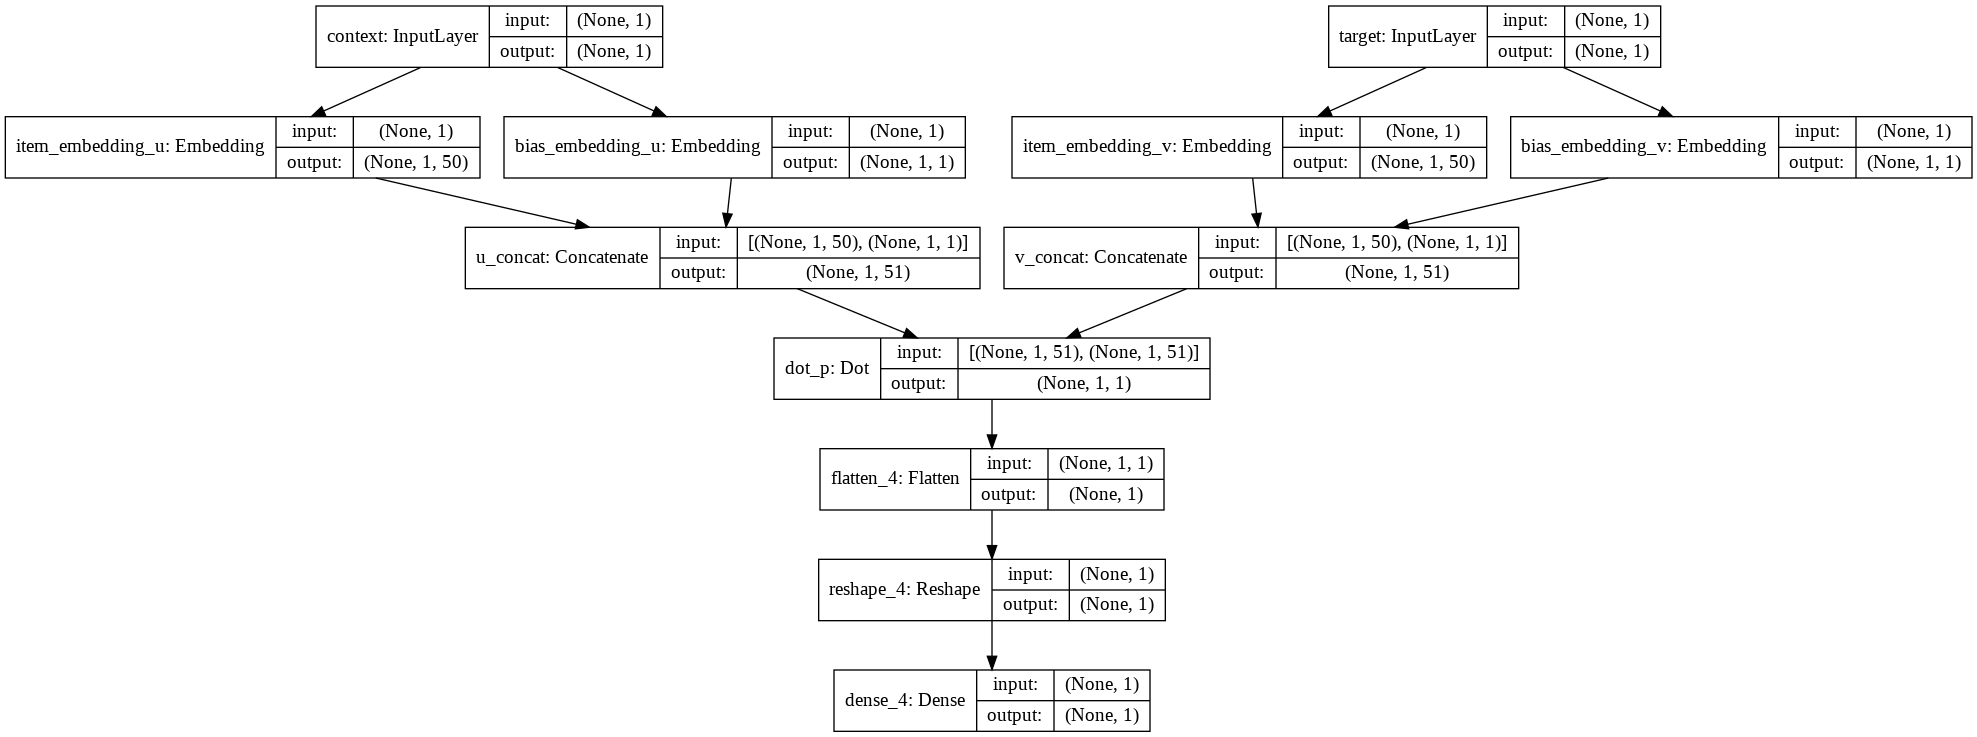

In [279]:
plot_model(I2V_bce, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model.png')

In [274]:
#Train the model
m_loss, acc, tr_auc, ts_auc, u_vecs, v_vecs, v_bias, u_bias = train(model = I2V_bce, 
                                                          traindata = trainset,
                                                          num_epochs = number_epochs, 
                                                          batch_size = batch_size, 
                                                          num_neg_samples = number_neg_samples, 
                                                          win_size = win_size, 
                                                          v = 2, 
                                                          shuffle = shuffle, 
                                                          neg_samples = neg_samples_list, 
                                                          s_t = s_t,  
                                                          loss = loss,
                                                          use_st = False)

Sampling data and creating skipgrams ...
5.31s
Creating couples and labels for model train ...0.18s
Sampling data and creating skipgrams ...
1.08s
Creating couples and labels for model train ...0.05s
Training item2vec model on 133 unique items and 100505 users
Epoch 1: Epoch 1/1
 - 4s - loss: 0.6584 - accuracy: 0.6468
Saving item embeddings after epoch
Epoch 2: Epoch 1/1
 - 4s - loss: 0.5781 - accuracy: 0.7224
Saving item embeddings after epoch
Epoch 3: Epoch 1/1
 - 4s - loss: 0.5077 - accuracy: 0.7766
Saving item embeddings after epoch
Epoch 4: Epoch 1/1
 - 4s - loss: 0.4748 - accuracy: 0.7937
Saving item embeddings after epoch
Epoch 5: Epoch 1/1
 - 4s - loss: 0.4563 - accuracy: 0.8015
Saving item embeddings after epoch
Epoch 6: Epoch 1/1
 - 4s - loss: 0.4441 - accuracy: 0.8059
Saving item embeddings after epoch
Epoch 7: Epoch 1/1
 - 4s - loss: 0.4352 - accuracy: 0.8095
Saving item embeddings after epoch
Epoch 8: Epoch 1/1
 - 4s - loss: 0.4285 - accuracy: 0.8129
Saving item embeddings

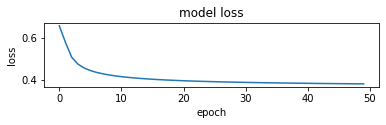

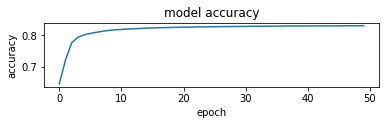

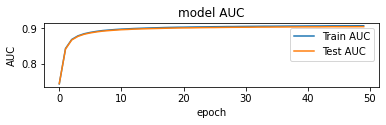

In [275]:
#Plot model metrics
plot_model_metrics(train_loss = m_loss, train_acc = acc, train_auc = tr_auc, test_auc = ts_auc)

## 3.2 Model 1 Evaluation

In [276]:
u_vecs_n_bias = {}
v_vecs_n_bias = {}
for i in range(number_epochs):
    u_vecs_n_bias[i] = np.concatenate((u_vecs[i], u_bias[i]), axis=1)
    v_vecs_n_bias[i] = np.concatenate((v_vecs[i], v_bias[i]), axis=1)

#### MPR

MPR calculations on Test Set after epoch: 1/10
MPR calculations on Train Set after epoch:  1/10
MPR calculations on Test Set after epoch: 2/10
MPR calculations on Train Set after epoch:  2/10
MPR calculations on Test Set after epoch: 3/10
MPR calculations on Train Set after epoch:  3/10
MPR calculations on Test Set after epoch: 4/10
MPR calculations on Train Set after epoch:  4/10
MPR calculations on Test Set after epoch: 5/10
MPR calculations on Train Set after epoch:  5/10
MPR calculations on Test Set after epoch: 6/10
MPR calculations on Train Set after epoch:  6/10
MPR calculations on Test Set after epoch: 7/10
MPR calculations on Train Set after epoch:  7/10
MPR calculations on Test Set after epoch: 8/10
MPR calculations on Train Set after epoch:  8/10
MPR calculations on Test Set after epoch: 9/10
MPR calculations on Train Set after epoch:  9/10
MPR calculations on Test Set after epoch: 10/10
MPR calculations on Train Set after epoch:  10/10


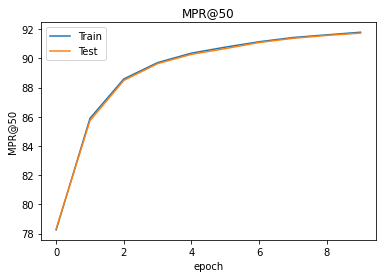

In [278]:
#Check how the MPR value changes with each epoch 
#Assuming it will decrease with each epoch we don't need to see all the way to the end
#Just to make sure how the graph looks

train_mpr50 = []
test_mpr50 = []
all_items = list(counts_by_idx.keys())
n = number_epochs - 40
for i in range(n): 
    #Test Set
    print('MPR calculations on Test Set after epoch: ' + str(i+1) + '/' + str(n))
    pr50 = []
    for couple in all_test_couples:
        k_recommendations = get_k_random_items(couple, all_items, k=50)
        relevant_item_embeddings = []
        for item in k_recommendations:
            relevant_item_embeddings.append(v_vecs_n_bias[i][item])
        relevant_item_embeddings = np.array(relevant_item_embeddings)
        most_similar_index = get_topk_similar2(u_vecs_n_bias[i][couple[0]], relevant_item_embeddings)
        most_similar_items = []
        for idx in most_similar_index:
            most_similar_items.append(k_recommendations[idx])
            
        pr50.append(pr(couple[1], most_similar_items))

    test_mpr50.append(np.mean(pr50))
   
    #Train Set
    print('MPR calculations on Train Set after epoch:  ' + str(i+1) + '/' + str(n))
    pr50 = []
    for couple in all_train_couples:
        k_recommendations = get_k_random_items(couple, all_items, k=50)
        relevant_item_embeddings = []
        for item in k_recommendations:
            relevant_item_embeddings.append(v_vecs_n_bias[i][item])
        relevant_item_embeddings = np.array(relevant_item_embeddings)
        most_similar_index = get_topk_similar2(u_vecs_n_bias[i][couple[0]], relevant_item_embeddings)
        most_similar_items = []
        for idx in most_similar_index:
            most_similar_items.append(k_recommendations[idx])
            
        pr50.append(pr(couple[1], most_similar_items))
        
    train_mpr50.append(np.mean(pr50))

plt.plot(train_mpr50)
plt.plot(test_mpr50)
plt.title('MPR@50')
plt.ylabel('MPR@50')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [62]:
#Get the MPR of the last epoch only 
#According to the graph above we can assume that with each epoch the MPR decreases,
#So the lowest MPR should be for the last epoch

number_epochs = 30

all_items = list(counts_by_idx.keys())

pr50 = []
for couple in all_test_couples:
    k_recommendations = get_k_random_items(couple, all_items, k=50)
    relevant_item_embeddings = []
    for item in k_recommendations:
        relevant_item_embeddings.append(v_vecs_n_bias[number_epochs-1][item])
    relevant_item_embeddings = np.array(relevant_item_embeddings)
    most_similar_index = get_topk_similar2(u_vecs_n_bias[number_epochs-1][couple[0]], relevant_item_embeddings)
    most_similar_items = []
    for idx in most_similar_index:
        most_similar_items.append(k_recommendations[idx])

    pr50.append(pr(couple[1], most_similar_items))

test_mpr50_last = np.mean(pr50)

pr50 = []
for couple in all_train_couples:
    k_recommendations = get_k_random_items(couple, all_items, k=50)
    relevant_item_embeddings = []
    for item in k_recommendations:
        relevant_item_embeddings.append(v_vecs_n_bias[number_epochs-1][item])
    relevant_item_embeddings = np.array(relevant_item_embeddings)
    most_similar_index = get_topk_similar2(u_vecs_n_bias[number_epochs-1][couple[0]], relevant_item_embeddings)
    most_similar_items = []
    for idx in most_similar_index:
        most_similar_items.append(k_recommendations[idx])

    pr50.append(pr(couple[1], most_similar_items))

train_mpr50_last = np.mean(pr50)

print('Model 1 - Loss: Binary Cross Entropy')
print('Train Set MPR@50:   ', train_mpr50_last)
print('Test Set MPR@50:    ', test_mpr50_last)

Model 1 - Loss: Binary Cross Entropy
Train Set MPR@50:    5.360271523548802
Test Set MPR@50:     5.435759712042373


#### HR

HR calculations on Test Set after epoch: 1/10
HR calculations on Train Set after epoch:  1/10
HR calculations on Test Set after epoch: 2/10
HR calculations on Train Set after epoch:  2/10
HR calculations on Test Set after epoch: 3/10
HR calculations on Train Set after epoch:  3/10
HR calculations on Test Set after epoch: 4/10
HR calculations on Train Set after epoch:  4/10
HR calculations on Test Set after epoch: 5/10
HR calculations on Train Set after epoch:  5/10
HR calculations on Test Set after epoch: 6/10
HR calculations on Train Set after epoch:  6/10
HR calculations on Test Set after epoch: 7/10
HR calculations on Train Set after epoch:  7/10
HR calculations on Test Set after epoch: 8/10
HR calculations on Train Set after epoch:  8/10
HR calculations on Test Set after epoch: 9/10
HR calculations on Train Set after epoch:  9/10
HR calculations on Test Set after epoch: 10/10
HR calculations on Train Set after epoch:  10/10


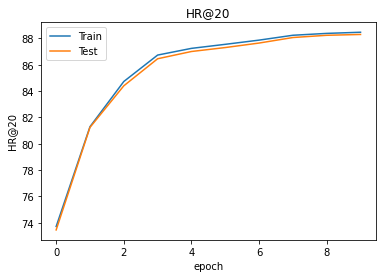

In [63]:
train_hr20 = []
test_hr20 = []
all_items = list(counts_by_idx.keys())

n = 10 # original 10 times

for i in range(n): 
    #Test Set
    print('HR calculations on Test Set after epoch: ' + str(i+1) + '/' + str(n))
    hr20 = []
    for couple in all_test_couples:
        most_similar_items = get_topk_similar2(u_vecs_n_bias[i][couple[0]], v_vecs_n_bias[i], k=20)           
        hr20.append(hr(couple[1], most_similar_items))

    test_hr20.append((np.sum(hr20)/len(all_test_couples))*100)
   
    #Train Set
    print('HR calculations on Train Set after epoch:  ' + str(i+1) + '/' + str(n))
    hr20 = []
    for couple in all_train_couples:
        most_similar_items = get_topk_similar2(u_vecs_n_bias[i][couple[0]], v_vecs_n_bias[i], k=20)
        hr20.append(hr(couple[1], most_similar_items))
        
    train_hr20.append((np.sum(hr20)/len(all_train_couples))*100)

plt.plot(train_hr20)
plt.plot(test_hr20)
plt.title('HR@20')
plt.ylabel('HR@20')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [64]:
#Get the HR of the last epoch only (the higher the better)
#According to the graph above we can assume that with each epoch the HR increases,
#So the highest HR should be for the last epoch

number_epochs = 30

hr20 = []
for couple in all_test_couples:
    most_similar_items = get_topk_similar2(u_vecs_n_bias[number_epochs-1][couple[0]], v_vecs_n_bias[number_epochs-1], k=20)           
    hr20.append(hr(couple[1], most_similar_items))

test_hr20_last = (np.sum(hr20)/len(all_test_couples))*100

hr20 = []
for couple in all_train_couples:
    most_similar_items = get_topk_similar2(u_vecs_n_bias[number_epochs-1][couple[0]], v_vecs_n_bias[number_epochs-1], k=20)           
    hr20.append(hr(couple[1], most_similar_items))

train_hr20_last = (np.sum(hr20)/len(all_train_couples))*100

print('Model 1 - Loss: Binary Cross Entropy')
print('Train Set HR@20:   ', train_hr20_last)
print('Test Set HR@20:    ', test_hr20_last)

Model 1 - Loss: Binary Cross Entropy
Train Set HR@20:    90.14237294448479
Test Set HR@20:     89.99235345679703


In [65]:
number_epochs = 30

hr10 = []
for couple in all_test_couples:
    most_similar_items = get_topk_similar2(u_vecs_n_bias[number_epochs-1][couple[0]], v_vecs_n_bias[number_epochs-1], k=10)           
    hr10.append(hr(couple[1], most_similar_items))

test_hr10_last = (np.sum(hr10)/len(all_test_couples))*100

hr10 = []
for couple in all_train_couples:
    most_similar_items = get_topk_similar2(u_vecs_n_bias[number_epochs-1][couple[0]], v_vecs_n_bias[number_epochs-1], k=10)           
    hr10.append(hr(couple[1], most_similar_items))

train_hr10_last = (np.sum(hr10)/len(all_train_couples))*100

print('Model 1 - Loss: Binary Cross Entropy')
print('Train Set HR@10:   ', train_hr10_last)
print('Test Set HR@10:    ', test_hr10_last)

Model 1 - Loss: Binary Cross Entropy
Train Set HR@10:    78.89965919883792
Test Set HR@10:     78.87502564389489


# 4. Model 2 - (Loss: Categorical Cross Entropy)

- Model: Skipgram with Negative Sampling
- Activation: **Softmax**
- Loss: **Categorical Cross Entropy**
- Optimizer: **SGD**
- Negative Samples: **1**
- Epochs: **150**
- Batch size: **128**

In [66]:
#Model 2 Hyperparameters
items_size = len(trainset_counts.keys())
missing = len(counts_by_idx) - len(trainset_counts) # For missing value
embedding_dim2 = 50
loss2 = 'categorical_ce'
opt2 = optimizers.SGD(lr=0.1)
metric2 = 'accuracy'

dual_embedding = True
bias = True

#Training hyperparameters
number_neg_samples2 = 1
win_size2 = 1
number_epochs2 = 150
batch_size2 = 128
shuffle2 = True

In [67]:
I2V_cce = create_I2Vmodel(items_size, 
                          embed_dim = embedding_dim2, 
                          loss = loss2, 
                          model_optimizer = opt2, 
                          model_metric = metric2, 
                          dual_embedding = dual_embedding, 
                          bias = bias)

In [68]:
I2V_cce.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
item_embedding_u (Embedding)    (None, 1, 50)        6650        context[0][0]                    
__________________________________________________________________________________________________
bias_embedding_u (Embedding)    (None, 1, 1)         133         context[0][0]                    
____________________________________________________________________________________________

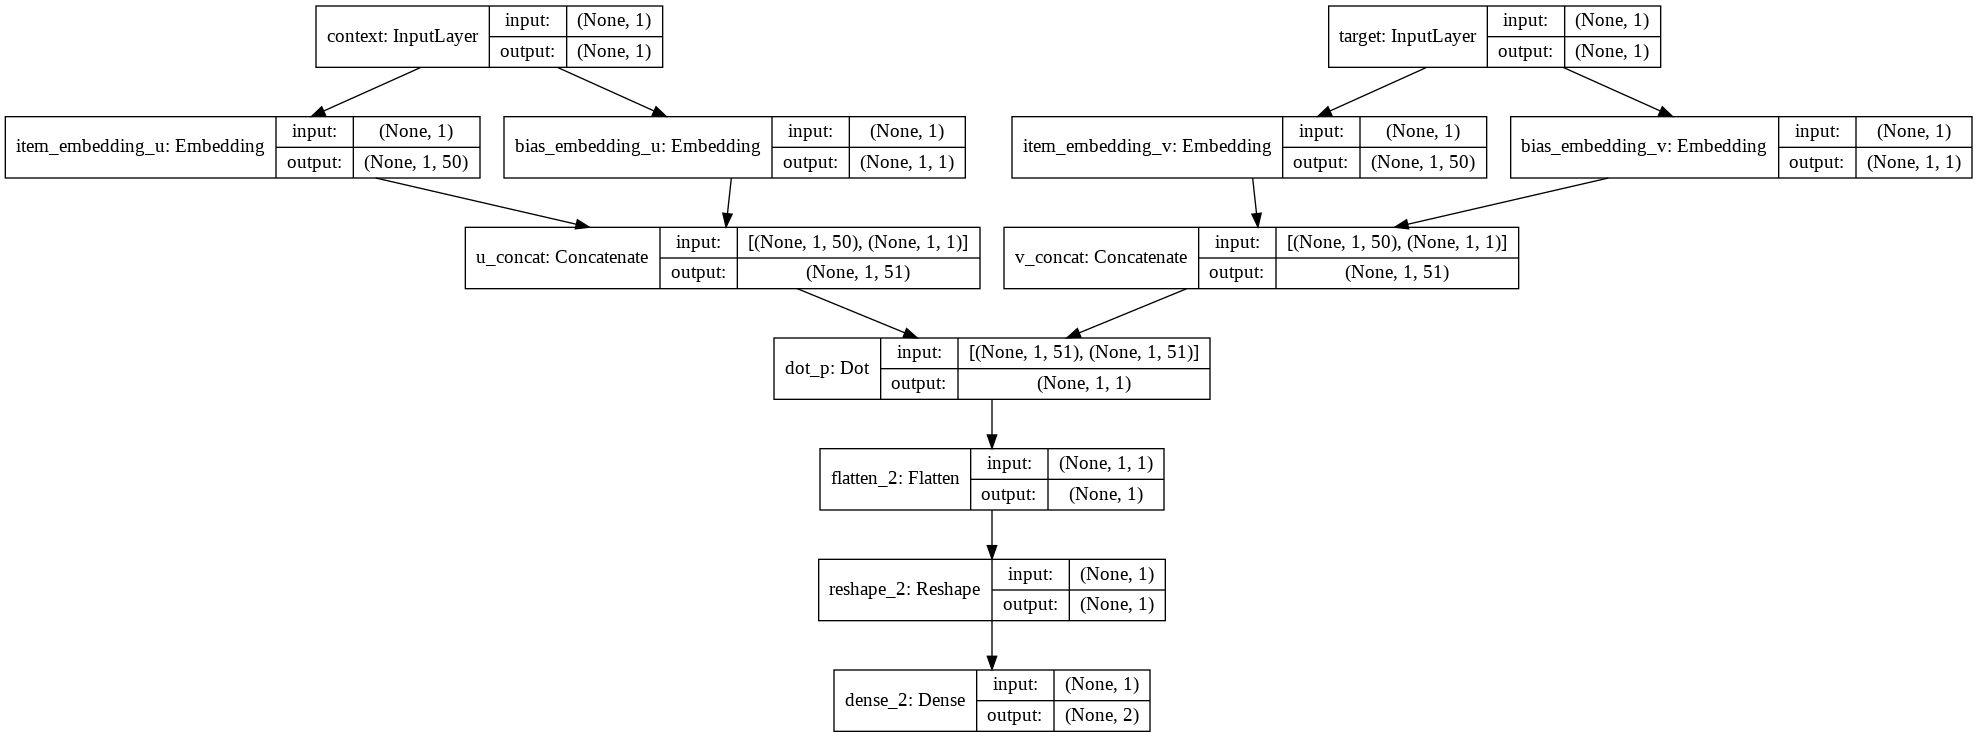

In [69]:
plot_model(I2V_cce, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model.png')

In [70]:
#Train the model
m_loss2, acc2, tr_auc2, ts_auc2, u_vecs2, v_vecs2, v_bias2, u_bias2 = train(model = I2V_cce, 
                                                          traindata = trainset,
                                                          num_epochs = number_epochs2, 
                                                          batch_size = batch_size2, 
                                                          num_neg_samples = number_neg_samples2, 
                                                          win_size = win_size2, 
                                                          v = 2, 
                                                          shuffle = shuffle2, 
                                                          neg_samples = neg_samples_list, 
                                                          s_t = s_t,  
                                                          loss = loss2,
                                                          use_st = False)

Sampling data and creating skipgrams ...
5.08s
Creating couples and labels for model train ...0.18s
Sampling data and creating skipgrams ...
1.52s
Creating couples and labels for model train ...0.05s
Training item2vec model on 133 unique items and 100505 users
Epoch 1: Epoch 1/1
 - 4s - loss: 0.6280 - accuracy: 0.6725
Saving item embeddings after epoch
Epoch 2: Epoch 1/1
 - 4s - loss: 0.5157 - accuracy: 0.7699
Saving item embeddings after epoch
Epoch 3: Epoch 1/1
 - 4s - loss: 0.4658 - accuracy: 0.7981
Saving item embeddings after epoch
Epoch 4: Epoch 1/1
 - 4s - loss: 0.4442 - accuracy: 0.8064
Saving item embeddings after epoch
Epoch 5: Epoch 1/1
 - 4s - loss: 0.4313 - accuracy: 0.8113
Saving item embeddings after epoch
Epoch 6: Epoch 1/1
 - 4s - loss: 0.4225 - accuracy: 0.8147
Saving item embeddings after epoch
Epoch 7: Epoch 1/1
 - 4s - loss: 0.4160 - accuracy: 0.8178
Saving item embeddings after epoch
Epoch 8: Epoch 1/1
 - 4s - loss: 0.4111 - accuracy: 0.8194
Saving item embeddings

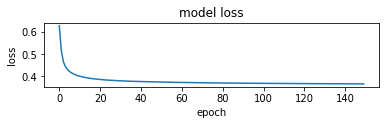

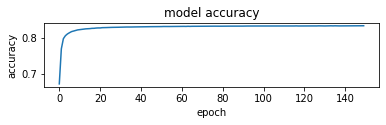

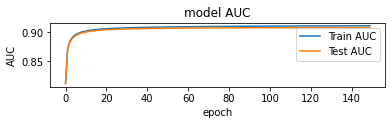

In [71]:
#Plot model metrics
plot_model_metrics(train_loss = m_loss2, train_acc = acc2, train_auc = tr_auc2, test_auc = ts_auc2)

## 4.2 Model 2 Evaluation

In [72]:
u_vecs_n_bias2 = {}
v_vecs_n_bias2 = {}
for i in range(number_epochs2):
    u_vecs_n_bias2[i] = np.concatenate((u_vecs2[i], u_bias2[i]), axis=1)
    v_vecs_n_bias2[i] = np.concatenate((v_vecs2[i], v_bias2[i]), axis=1)

#### MPR

MPR calculations on Test Set after epoch: 1/50
MPR calculations on Train Set after epoch:  1/50
MPR calculations on Test Set after epoch: 2/50
MPR calculations on Train Set after epoch:  2/50
MPR calculations on Test Set after epoch: 3/50
MPR calculations on Train Set after epoch:  3/50
MPR calculations on Test Set after epoch: 4/50
MPR calculations on Train Set after epoch:  4/50
MPR calculations on Test Set after epoch: 5/50
MPR calculations on Train Set after epoch:  5/50
MPR calculations on Test Set after epoch: 6/50
MPR calculations on Train Set after epoch:  6/50
MPR calculations on Test Set after epoch: 7/50
MPR calculations on Train Set after epoch:  7/50
MPR calculations on Test Set after epoch: 8/50
MPR calculations on Train Set after epoch:  8/50
MPR calculations on Test Set after epoch: 9/50
MPR calculations on Train Set after epoch:  9/50
MPR calculations on Test Set after epoch: 10/50
MPR calculations on Train Set after epoch:  10/50
MPR calculations on Test Set after epo

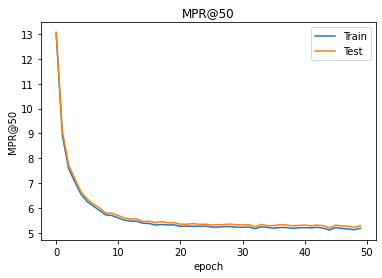

In [73]:
train_mpr50_2 = []
test_mpr50_2 = []
all_items = list(counts_by_idx.keys())
n=number_epochs2 -100
for i in range(n): 
    #Test Set
    print('MPR calculations on Test Set after epoch: ' + str(i+1) + '/' + str(n))
    pr50 = []
    for couple in all_test_couples:
        k_recommendations = get_k_random_items(couple, all_items, k=50)
        relevant_item_embeddings = []
        for item in k_recommendations:
            relevant_item_embeddings.append(v_vecs_n_bias2[i][item])
        relevant_item_embeddings = np.array(relevant_item_embeddings)
        most_similar_index = get_topk_similar2(u_vecs_n_bias2[i][couple[0]], relevant_item_embeddings)
        most_similar_items = []
        for idx in most_similar_index:
            most_similar_items.append(k_recommendations[idx])
            
        pr50.append(pr(couple[1], most_similar_items))

    test_mpr50_2.append(np.mean(pr50))
   
    #Train Set
    print('MPR calculations on Train Set after epoch:  ' + str(i+1) + '/' + str(n))
    pr50 = []
    for couple in all_train_couples:
        k_recommendations = get_k_random_items(couple, all_items, k=50)
        relevant_item_embeddings = []
        for item in k_recommendations:
            relevant_item_embeddings.append(v_vecs_n_bias2[i][item])
        relevant_item_embeddings = np.array(relevant_item_embeddings)
        most_similar_index = get_topk_similar2(u_vecs_n_bias2[i][couple[0]], relevant_item_embeddings)
        most_similar_items = []
        for idx in most_similar_index:
            most_similar_items.append(k_recommendations[idx])
            
        pr50.append(pr(couple[1], most_similar_items))
        
    train_mpr50_2.append(np.mean(pr50))

plt.plot(train_mpr50_2)
plt.plot(test_mpr50_2)
plt.title('MPR@50')
plt.ylabel('MPR@50')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [74]:
#Get the MPR of the last epoch only 
#According to the graph above we can assume that with each epoch the MPR decreases,
#So the lowest MPR should be for the last epoch

number_epochs2 = 100

all_items = list(counts_by_idx.keys())

pr50_2 = []
for couple in all_test_couples:
    k_recommendations2 = get_k_random_items(couple, all_items, k=50)
    relevant_item_embeddings2 = []
    for item in k_recommendations2:
        relevant_item_embeddings2.append(v_vecs_n_bias2[number_epochs2-1][item])
    relevant_item_embeddings2 = np.array(relevant_item_embeddings2)
    most_similar_index2 = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]], relevant_item_embeddings2)
    most_similar_items2 = []
    for idx in most_similar_index2:
        most_similar_items2.append(k_recommendations2[idx])

    pr50_2.append(pr(couple[1], most_similar_items2))

test_mpr50_2_last = np.mean(pr50_2)

pr50_2 = []
for couple in all_train_couples:
    k_recommendations2 = get_k_random_items(couple, all_items, k=50)
    relevant_item_embeddings2 = []
    for item in k_recommendations2:
        relevant_item_embeddings2.append(v_vecs_n_bias2[number_epochs2-1][item])
    relevant_item_embeddings2 = np.array(relevant_item_embeddings2)
    most_similar_index2 = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]], relevant_item_embeddings2)
    most_similar_items2 = []
    for idx in most_similar_index2:
        most_similar_items2.append(k_recommendations2[idx])

    pr50_2.append(pr(couple[1], most_similar_items2))

train_mpr50_2_last = np.mean(pr50_2)

print('Model 2 - Loss: Categorical Cross Entropy')
print('Train Set MPR:   ', train_mpr50_2_last)
print('Test Set MPR :    ', test_mpr50_2_last)

Model 2 - Loss: Categorical Cross Entropy
Train Set MPR:    5.16010205411848
Test Set MPR :     5.280553535127473


#### HR

HR calculations on Test Set after epoch: 1/10
HR calculations on Train Set after epoch:  1/10
HR calculations on Test Set after epoch: 2/10
HR calculations on Train Set after epoch:  2/10
HR calculations on Test Set after epoch: 3/10
HR calculations on Train Set after epoch:  3/10
HR calculations on Test Set after epoch: 4/10
HR calculations on Train Set after epoch:  4/10
HR calculations on Test Set after epoch: 5/10
HR calculations on Train Set after epoch:  5/10
HR calculations on Test Set after epoch: 6/10
HR calculations on Train Set after epoch:  6/10
HR calculations on Test Set after epoch: 7/10
HR calculations on Train Set after epoch:  7/10
HR calculations on Test Set after epoch: 8/10
HR calculations on Train Set after epoch:  8/10
HR calculations on Test Set after epoch: 9/10
HR calculations on Train Set after epoch:  9/10
HR calculations on Test Set after epoch: 10/10
HR calculations on Train Set after epoch:  10/10


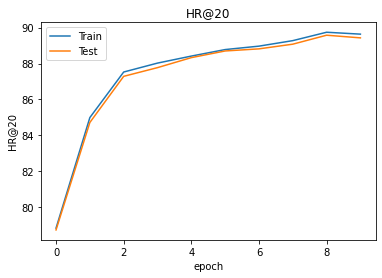

In [75]:
train_hr20_2 = []
test_hr20_2 = []

n = 10

for i in range(n): 
    #Test Set
    print('HR calculations on Test Set after epoch: ' + str(i+1) + '/' + str(n))
    hr20 = []
    for couple in all_test_couples:
        most_similar_items = get_topk_similar2(u_vecs_n_bias2[i][couple[0]], v_vecs_n_bias2[i], k=20)           
        hr20.append(hr(couple[1], most_similar_items))

    test_hr20_2.append((np.sum(hr20)/len(all_test_couples))*100)
   
    #Train Set
    print('HR calculations on Train Set after epoch:  ' + str(i+1) + '/' + str(n))
    hr20 = []
    for couple in all_train_couples:
        most_similar_items = get_topk_similar2(u_vecs_n_bias2[i][couple[0]], v_vecs_n_bias2[i], k=20)
        hr20.append(hr(couple[1], most_similar_items))
        
    train_hr20_2.append((np.sum(hr20)/len(all_train_couples))*100)

plt.plot(train_hr20_2)
plt.plot(test_hr20_2)
plt.title('HR@20')
plt.ylabel('HR@20')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [76]:
#Get the HR of the last epoch only (the higher the better)
#According to the graph above we can assume that with each epoch the HR increases,
#So the highest HR should be for the last epoch

number_epochs2 = 100

hr20_2 = []
for couple in all_test_couples:
    most_similar_items2 = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]],
                                            v_vecs_n_bias2[number_epochs2-1],
                                            k=20)           
    hr20_2.append(hr(couple[1], most_similar_items2))

test_hr20_2_last = (np.sum(hr20_2)/len(all_test_couples))*100

hr20_2 = []
for couple in all_train_couples:
    most_similar_items2 = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]],
                                            v_vecs_n_bias2[number_epochs2-1],
                                            k=20)           
    hr20_2.append(hr(couple[1], most_similar_items2))

train_hr20_2_last = (np.sum(hr20_2)/len(all_train_couples))*100

print('Model 2 - Loss: Categorical Cross Entropy')
print('Train Set HR@20:   ', train_hr20_2_last)
print('Test Set HR@20:    ', test_hr20_2_last)

Model 2 - Loss: Categorical Cross Entropy
Train Set HR@20:    89.48218708680187
Test Set HR@20:     89.23329416811205


In [77]:
number_epochs2 = 100

hr10_2 = []
for couple in all_test_couples:
    most_similar_items2 = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]],
                                            v_vecs_n_bias2[number_epochs2-1],
                                            k=10)           
    hr10_2.append(hr(couple[1], most_similar_items2))

test_hr10_2_last = (np.sum(hr10_2)/len(all_test_couples))*100

hr10_2 = []
for couple in all_train_couples:
    most_similar_items2 = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]],
                                            v_vecs_n_bias2[number_epochs-1],
                                            k=10)           
    hr10_2.append(hr(couple[1], most_similar_items2))

train_hr10_2_last = (np.sum(hr10_2)/len(all_train_couples))*100

print('Model 2 - Loss: Categorical Cross Entropy')
print('Train Set HR@10:   ', train_hr10_2_last)
print('Test Set HR@10:    ', test_hr10_2_last)

Model 2 - Loss: Categorical Cross Entropy
Train Set HR@10:    78.99556772259157
Test Set HR@10:     77.8026445849419


In [78]:
number_epochs2 = 100

hr20 = []
for couple in all_test_couples:
    most_similar_items = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]], v_vecs_n_bias2[number_epochs2-1], k=20)           
    hr20.append(hr(couple[1], most_similar_items))

test_hr20_2_last2 = (np.sum(hr20)/len(all_test_couples))*100

hr20 = []
for couple in all_train_couples:
    most_similar_items = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]], v_vecs_n_bias2[number_epochs2-1], k=20)           
    hr20.append(hr(couple[1], most_similar_items))

train_hr20_2_last2 = (np.sum(hr20)/len(all_train_couples))*100

print('Train Set HR@20:   ', train_hr20_2_last2)
print('Test Set HR@20:    ', test_hr20_2_last2)

Train Set HR@20:    89.48218708680187
Test Set HR@20:     89.23329416811205


In [79]:
number_epochs2 = 100

hr10_2 = []
for couple in all_test_couples:
    most_similar_items2 = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]],
                                            v_vecs_n_bias2[number_epochs2-1],
                                            k=10)           
    hr10_2.append(hr(couple[1], most_similar_items2))

test_hr10_2_last2 = (np.sum(hr10_2)/len(all_test_couples))*100

hr10_2 = []
for couple in all_train_couples:
    most_similar_items2 = get_topk_similar2(u_vecs_n_bias2[number_epochs2-1][couple[0]],
                                            v_vecs_n_bias2[number_epochs2-1],
                                            k=10)           
    hr10_2.append(hr(couple[1], most_similar_items2))

train_hr10_2_last2 = (np.sum(hr10_2)/len(all_train_couples))*100

print('Model 2 - Loss: Categorical Cross Entropy')
print('Train Set HR@10:   ', train_hr10_2_last2)
print('Test Set HR@10:    ', test_hr10_2_last2)

Model 2 - Loss: Categorical Cross Entropy
Train Set HR@10:    78.03555133433898
Test Set HR@10:     77.8026445849419


# 5. Model 3 - (Loss: Hinge)

- Model: Skipgram with Negative Sampling
- Activation: **Linear**
- Loss: **Hinge**
- Optimizer: **SGD**
- Negative Samples: **1**
- Epochs: **50**
- Batch size: **128**

In [80]:
#Model 3 Hyperparameters
items_size = len(trainset_counts.keys())
embedding_dim3 = 50
loss3 = 'hinge'
opt3 = optimizers.SGD(lr=0.1)
metric3 = 'accuracy'

dual_embedding = True
bias = True

#Training hyperparameters
number_neg_samples3 = 1
win_size3 = 1
number_epochs3 = 150
batch_size3 = 128
shuffle3 = True

In [81]:
I2V_h = create_I2Vmodel(items_size, 
                          embed_dim = embedding_dim3, 
                          loss = loss3, 
                          model_optimizer = opt3, 
                          model_metric = metric3, 
                          dual_embedding = dual_embedding, 
                          bias = bias)

In [82]:
I2V_h.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
item_embedding_u (Embedding)    (None, 1, 50)        6650        context[0][0]                    
__________________________________________________________________________________________________
bias_embedding_u (Embedding)    (None, 1, 1)         133         context[0][0]                    
____________________________________________________________________________________________

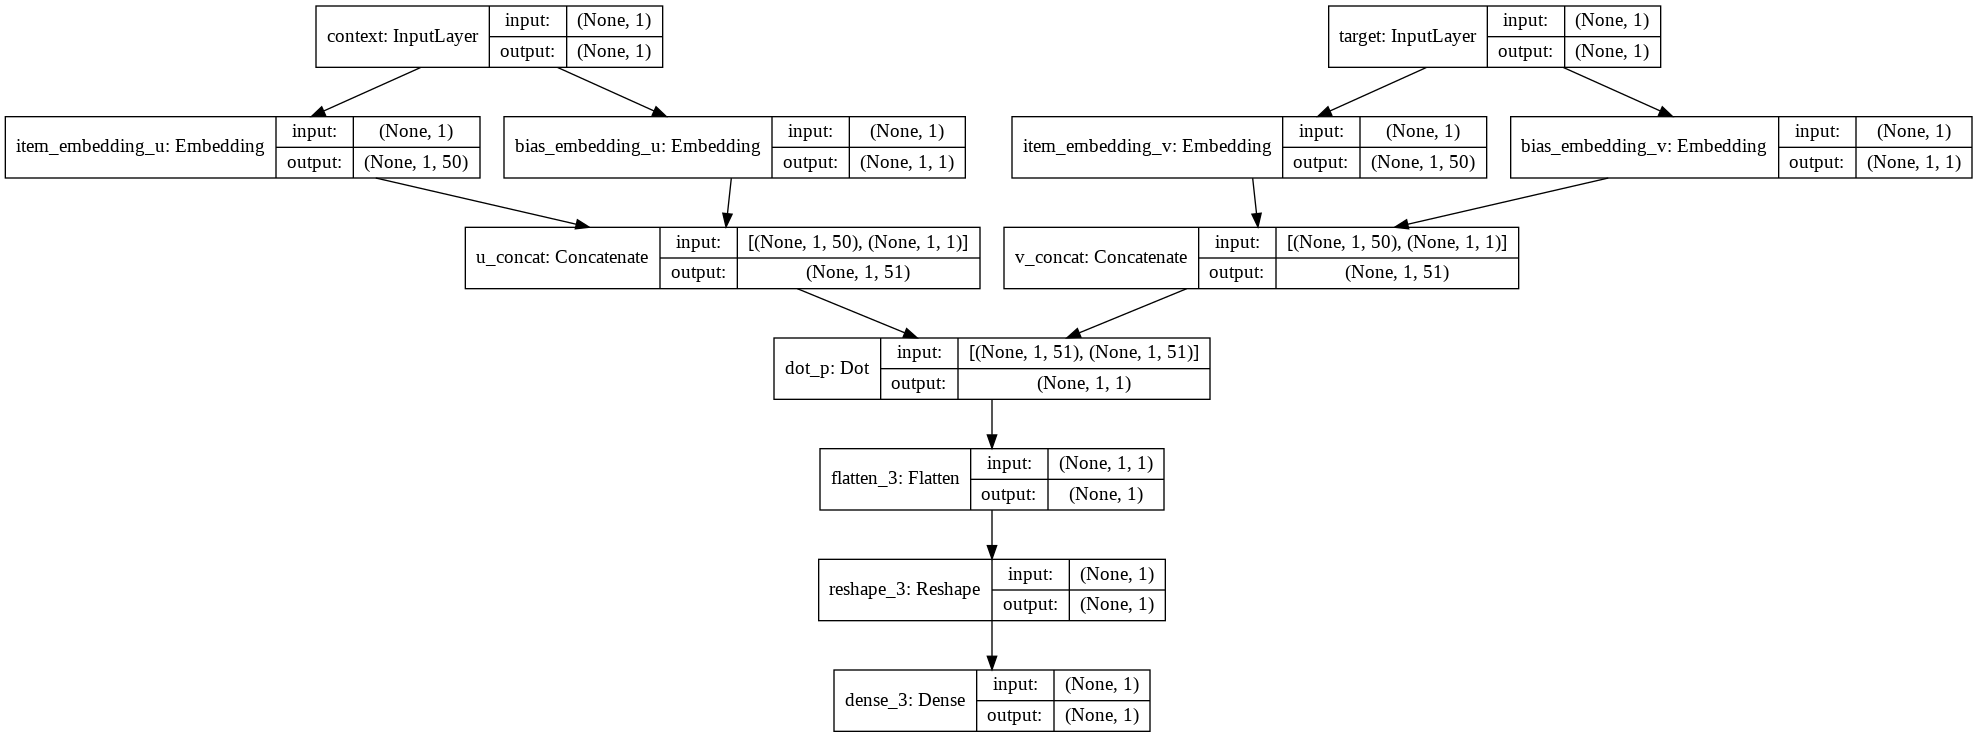

In [83]:
plot_model(I2V_h, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model.png')

In [84]:
#Train the model
m_loss3, acc3, tr_auc3, ts_auc3, u_vecs3, v_vecs3, v_bias3, u_bias3 = train(model = I2V_h, 
                                                          traindata = trainset,
                                                          num_epochs = number_epochs3, 
                                                          batch_size = batch_size3, 
                                                          num_neg_samples = number_neg_samples3, 
                                                          win_size = win_size3, 
                                                          v = 2, 
                                                          shuffle = shuffle3, 
                                                          neg_samples = neg_samples_list, 
                                                          s_t = s_t,  
                                                          loss = loss3,
                                                          use_st = False)

Sampling data and creating skipgrams ...
4.99s
Creating couples and labels for model train ...0.21s
Sampling data and creating skipgrams ...
1.45s
Creating couples and labels for model train ...0.04s
Training item2vec model on 133 unique items and 100505 users
Epoch 1: Epoch 1/1
 - 4s - loss: 0.5834 - accuracy: 0.5453
Saving item embeddings after epoch
Epoch 2: Epoch 1/1
 - 4s - loss: 0.4090 - accuracy: 0.6869
Saving item embeddings after epoch
Epoch 3: Epoch 1/1
 - 4s - loss: 0.3868 - accuracy: 0.7072
Saving item embeddings after epoch
Epoch 4: Epoch 1/1
 - 4s - loss: 0.3763 - accuracy: 0.7223
Saving item embeddings after epoch
Epoch 5: Epoch 1/1
 - 4s - loss: 0.3695 - accuracy: 0.7316
Saving item embeddings after epoch
Epoch 6: Epoch 1/1
 - 4s - loss: 0.3647 - accuracy: 0.7420
Saving item embeddings after epoch
Epoch 7: Epoch 1/1
 - 4s - loss: 0.3612 - accuracy: 0.7456
Saving item embeddings after epoch
Epoch 8: Epoch 1/1
 - 4s - loss: 0.3587 - accuracy: 0.7501
Saving item embeddings

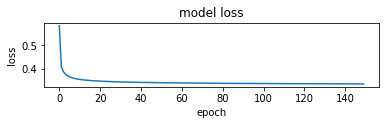

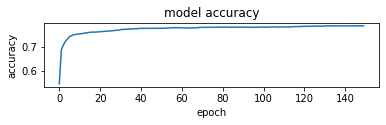

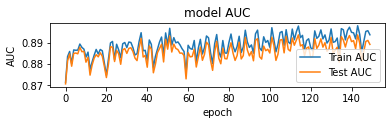

In [85]:
#Plot model metrics
plot_model_metrics(train_loss = m_loss3, train_acc = acc3, train_auc = tr_auc3, test_auc = ts_auc3)

## 5.2 Model 3 Evaluation

In [86]:
u_vecs_n_bias3 = {}
v_vecs_n_bias3 = {}
for i in range(number_epochs3):
    u_vecs_n_bias3[i] = np.concatenate((u_vecs3[i], u_bias3[i]), axis=1)
    v_vecs_n_bias3[i] = np.concatenate((v_vecs3[i], v_bias3[i]), axis=1)

#### MPR

MPR calculations on Test Set after epoch: 1/50
MPR calculations on Train Set after epoch:  1/50
MPR calculations on Test Set after epoch: 2/50
MPR calculations on Train Set after epoch:  2/50
MPR calculations on Test Set after epoch: 3/50
MPR calculations on Train Set after epoch:  3/50
MPR calculations on Test Set after epoch: 4/50
MPR calculations on Train Set after epoch:  4/50
MPR calculations on Test Set after epoch: 5/50
MPR calculations on Train Set after epoch:  5/50
MPR calculations on Test Set after epoch: 6/50
MPR calculations on Train Set after epoch:  6/50
MPR calculations on Test Set after epoch: 7/50
MPR calculations on Train Set after epoch:  7/50
MPR calculations on Test Set after epoch: 8/50
MPR calculations on Train Set after epoch:  8/50
MPR calculations on Test Set after epoch: 9/50
MPR calculations on Train Set after epoch:  9/50
MPR calculations on Test Set after epoch: 10/50
MPR calculations on Train Set after epoch:  10/50
MPR calculations on Test Set after epo

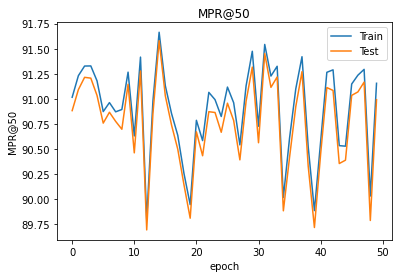

In [87]:
train_mpr50_3 = []
test_mpr50_3 = []
all_items = list(counts_by_idx.keys())
n=number_epochs3- 100
for i in range(n): 
    #Test Set
    print('MPR calculations on Test Set after epoch: ' + str(i+1) + '/' + str(n))
    pr50 = []
    for couple in all_test_couples:
        k_recommendations = get_k_random_items(couple, all_items, k=50)
        relevant_item_embeddings = []
        for item in k_recommendations:
            relevant_item_embeddings.append(v_vecs_n_bias3[i][item])
        relevant_item_embeddings = np.array(relevant_item_embeddings)
        most_similar_index = get_topk_similar2(u_vecs_n_bias3[i][couple[0]], relevant_item_embeddings)
        most_similar_items = []
        for idx in most_similar_index:
            most_similar_items.append(k_recommendations[idx])
            
        pr50.append(pr(couple[1], most_similar_items))

    test_mpr50_3.append(np.mean(pr50))
   
    #Train Set
    print('MPR calculations on Train Set after epoch:  ' + str(i+1) + '/' + str(n))
    pr50 = []
    for couple in all_train_couples:
        k_recommendations = get_k_random_items(couple, all_items, k=50)
        relevant_item_embeddings = []
        for item in k_recommendations:
            relevant_item_embeddings.append(v_vecs_n_bias3[i][item])
        relevant_item_embeddings = np.array(relevant_item_embeddings)
        most_similar_index = get_topk_similar2(u_vecs_n_bias3[i][couple[0]], relevant_item_embeddings)
        most_similar_items = []
        for idx in most_similar_index:
            most_similar_items.append(k_recommendations[idx])
            
        pr50.append(pr(couple[1], most_similar_items))
        
    train_mpr50_3.append(np.mean(pr50))

plt.plot(train_mpr50_3)
plt.plot(test_mpr50_3)
plt.title('MPR@50')
plt.ylabel('MPR@50')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [88]:
#Get the MPR of the last epoch only 
#According to the graph above we can assume that with each epoch the MPR decreases,
#So the lowest MPR should be for the last epoch

number_epochs3 = 100

all_items = list(counts_by_idx.keys())

pr50_3 = []
for couple in all_test_couples:
    k_recommendations3 = get_k_random_items(couple, all_items, k=50)
    relevant_item_embeddings3 = []
    for item in k_recommendations3:
        relevant_item_embeddings3.append(v_vecs_n_bias3[number_epochs3-1][item])
    relevant_item_embeddings3 = np.array(relevant_item_embeddings3)
    most_similar_index3 = get_topk_similar2(u_vecs_n_bias3[number_epochs3-1][couple[0]], relevant_item_embeddings3)
    most_similar_items3 = []
    for idx in most_similar_index3:
        most_similar_items3.append(k_recommendations3[idx])

    pr50_3.append(pr(couple[1], most_similar_items3))

test_mpr50_3_last = np.mean(pr50_3)

pr50_3 = []
for couple in all_train_couples:
    k_recommendations3 = get_k_random_items(couple, all_items, k=50)
    relevant_item_embeddings3 = []
    for item in k_recommendations3:
        relevant_item_embeddings3.append(v_vecs_n_bias3[number_epochs3-1][item])
    relevant_item_embeddings3 = np.array(relevant_item_embeddings3)
    most_similar_index3 = get_topk_similar2(u_vecs_n_bias3[number_epochs3-1][couple[0]], relevant_item_embeddings3)
    most_similar_items3 = []
    for idx in most_similar_index3:
        most_similar_items3.append(k_recommendations3[idx])

    pr50_3.append(pr(couple[1], most_similar_items3))

train_mpr50_3_last = np.mean(pr50_3)

print('Model 3 - Loss: Hinge')
print('Train Set MPR:   ', train_mpr50_3_last)
print('Test Set MPR :    ', test_mpr50_3_last)

Model 3 - Loss: Hinge
Train Set MPR:    91.19013166471125
Test Set MPR :     90.97129748783081


#### HR

HR calculations on Test Set after epoch: 1/10
HR calculations on Train Set after epoch:  1/10
HR calculations on Test Set after epoch: 2/10
HR calculations on Train Set after epoch:  2/10
HR calculations on Test Set after epoch: 3/10
HR calculations on Train Set after epoch:  3/10
HR calculations on Test Set after epoch: 4/10
HR calculations on Train Set after epoch:  4/10
HR calculations on Test Set after epoch: 5/10
HR calculations on Train Set after epoch:  5/10
HR calculations on Test Set after epoch: 6/10
HR calculations on Train Set after epoch:  6/10
HR calculations on Test Set after epoch: 7/10
HR calculations on Train Set after epoch:  7/10
HR calculations on Test Set after epoch: 8/10
HR calculations on Train Set after epoch:  8/10
HR calculations on Test Set after epoch: 9/10
HR calculations on Train Set after epoch:  9/10
HR calculations on Test Set after epoch: 10/10
HR calculations on Train Set after epoch:  10/10


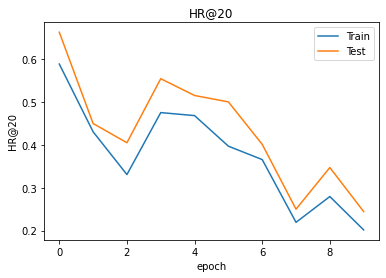

In [89]:
train_hr20_3 = []
test_hr20_3 = []

n = 10

for i in range(n): 
    #Test Set
    print('HR calculations on Test Set after epoch: ' + str(i+1) + '/' + str(n))
    hr20 = []
    for couple in all_test_couples:
        most_similar_items = get_topk_similar2(u_vecs_n_bias3[i][couple[0]], v_vecs_n_bias3[i], k=20)           
        hr20.append(hr(couple[1], most_similar_items))

    test_hr20_3.append((np.sum(hr20)/len(all_test_couples))*100)
   
    #Train Set
    print('HR calculations on Train Set after epoch:  ' + str(i+1) + '/' + str(n))
    hr20 = []
    for couple in all_train_couples:
        most_similar_items = get_topk_similar2(u_vecs_n_bias3[i][couple[0]], v_vecs_n_bias3[i], k=20)
        hr20.append(hr(couple[1], most_similar_items))
        
    train_hr20_3.append((np.sum(hr20)/len(all_train_couples))*100)

plt.plot(train_hr20_3)
plt.plot(test_hr20_3)
plt.title('HR@20')
plt.ylabel('HR@20')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [90]:
#Get the HR of the last epoch only (the higher the better)
#According to the graph above we can assume that with each epoch the HR increases,
#So the highest HR should be for the last epoch

number_epochs3 = 100

hr20_3 = []
for couple in all_test_couples:
    most_similar_items3 = get_topk_similar2(u_vecs_n_bias3[number_epochs3-1][couple[0]],
                                            v_vecs_n_bias3[number_epochs3-1], k=20)           
    hr20_3.append(hr(couple[1], most_similar_items3))

test_hr20_3_last = (np.sum(hr20_3)/len(all_test_couples))*100

hr20_3 = []
for couple in all_train_couples:
    most_similar_items3 = get_topk_similar2(u_vecs_n_bias3[number_epochs3-1][couple[0]],
                                            v_vecs_n_bias3[number_epochs3-1], k=20)           
    hr20_3.append(hr(couple[1], most_similar_items3))

train_hr20_3_last = (np.sum(hr20_3)/len(all_train_couples))*100

print('Model 3 - Loss: Hinge')
print('Train Set HR@20:   ', train_hr20_3_last)
print('Test Set HR@20:    ', test_hr20_3_last)

Model 3 - Loss: Hinge
Train Set HR@20:    0.023744343259399964
Test Set HR@20:     0.11376564277588168


In [91]:
number_epochs3 = 100

hr10_3 = []
for couple in all_test_couples:
    most_similar_items3 = get_topk_similar2(u_vecs_n_bias3[number_epochs3-1][couple[0]],
                                            v_vecs_n_bias3[number_epochs3-1],
                                            k=10)           
    hr10_3.append(hr(couple[1], most_similar_items3))

test_hr10_3_last = (np.sum(hr10_3)/len(all_test_couples))*100

hr10_3 = []
for couple in all_train_couples:
    most_similar_items3 = get_topk_similar2(u_vecs_n_bias3[number_epochs3-1][couple[0]],
                                            v_vecs_n_bias3[number_epochs3-1],
                                            k=10)           
    hr10_3.append(hr(couple[1], most_similar_items3))

train_hr10_3_last = (np.sum(hr10_3)/len(all_train_couples))*100

print('Model 3 - Loss: Hinge')
print('Train Set HR@10:   ', train_hr10_3_last)
print('Test Set HR@10:    ', test_hr10_3_last)

Model 3 - Loss: Hinge
Train Set HR@10:    0.007914781086466656
Test Set HR@10:     0.037300210746190714


# 6. Baseline Method 1 - ItemPop

#### MPR

In [92]:
all_items = list(counts_by_idx.keys())
sorted_by_popularity = counts_by_idx.most_common()

#Test Set
pr50_b1 = []
for i, couple in enumerate(all_test_couples):
    k_recommendations_b1 = get_k_random_items(couple, all_items, k=50)
    relevant_items_b1 = []
    for item in k_recommendations_b1:
        relevant_items_b1.append(sorted_by_popularity[item])
    most_popular_b1 = list(reversed(sorted(relevant_items_b1, key=lambda x: x[1])))
    most_popular_b1 = [x[0] for x in most_popular_b1]

    pr50_b1.append(pr(couple[1], most_popular_b1))

test_mpr50_b1 = np.mean(pr50_b1)

#Train Set
pr50_b1 = []
for i,couple in enumerate(all_train_couples):
    k_recommendations_b1 = get_k_random_items(couple, all_items, k=50)
    relevant_items_b1 = []
    for item in k_recommendations_b1:
        relevant_items_b1.append(sorted_by_popularity[item])
    most_popular_b1 = list(reversed(sorted(relevant_items_b1, key=lambda x: x[1])))
    most_popular_b1 = [x[0] for x in most_popular_b1]

    pr50_b1.append(pr(couple[1], most_popular_b1))

train_mpr50_b1 = np.mean(pr50_b1)

print('Baseline Method 1 - ItemPop')
print('Train Set MPR:   ', train_mpr50_b1)
print('Test Set MPR:    ', test_mpr50_b1)

Baseline Method 1 - ItemPop
Train Set MPR:    11.64670279531445
Test Set MPR:     11.768104589790932


#### HR

In [93]:
train_popular = trainset_counts.most_common()
test_popular = testset_counts.most_common()

k=20

#Test Set
hr20_b1 = []
for couple in all_test_couples:
    k_recommendations_b1 = test_popular[:k]
    most_popular_b1 = [x[0] for x in k_recommendations_b1]

    hr20_b1.append(hr(couple[1], most_popular_b1))

test_hr20_b1 = (np.sum(hr20_b1)/len(all_test_couples))*100

#Train Set
hr20 = []
for couple in all_train_couples:
    k_recommendations_b1 = train_popular[:k]
    most_popular_b1 = [x[0] for x in k_recommendations_b1]

    hr20_b1.append(hr(couple[1], most_popular_b1))

train_hr20_b1 = (np.sum(hr20_b1)/len(all_test_couples))*100

print('Baseline Method 1 - ItemPop')
print('Train Set HR@20:   ', train_hr20_b1)
print('Test Set HR@20:    ', test_hr20_b1)

Baseline Method 1 - ItemPop
Train Set HR@20:    362.8359350230329
Test Set HR@20:     72.27848337343106


In [94]:
k=10

#Test Set
hr10_b1 = []
for couple in all_test_couples:
    k_recommendations_b1 = test_popular[:k]
    most_popular_b1 = [x[0] for x in k_recommendations_b1]

    hr10_b1.append(hr(couple[1], most_popular_b1))

test_hr10_b1 = (np.sum(hr10_b1)/len(all_test_couples))*100

#Train Set
hr10 = []
for couple in all_train_couples:
    k_recommendations_b1 = train_popular[:k]
    most_popular_b1 = [x[0] for x in k_recommendations_b1]

    hr10_b1.append(hr(couple[1], most_popular_b1))

train_hr10_b1 = (np.sum(hr10_b1)/len(all_test_couples))*100

print('Baseline Method 1 - ItemPop')
print('Train Set HR@10:   ', train_hr10_b1)
print('Test Set HR@10:    ', test_hr10_b1)

Baseline Method 1 - ItemPop
Train Set HR@10:    275.2867453701113
Test Set HR@10:     54.94507543967624


#### AUC

In [95]:
all_items = list(counts_by_idx.keys())
sorted_by_popularity = counts_by_idx.most_common()

#Test Set
pred_b1 = []
actuals_b1 = []
for i, couple in enumerate(all_test_couples):
    k_recommendations_b1 = get_k_random_items(couple, all_items, k=50)
    relevant_items_b1 = []
    for item in k_recommendations_b1:
        relevant_items_b1.append(sorted_by_popularity[item])
    most_popular_b1 = list(reversed(sorted(relevant_items_b1, key=lambda x: x[1])))
    most_popular_b1 = [x[0] for x in most_popular_b1]
    if most_popular_b1[0] == couple[1]:
        pred_b1.append(1)
        actuals_b1.append(1)
    else:
        pred_b1.append(1)
        actuals_b1.append(0)
        

test_auc_b1 = roc_auc_score(actuals_b1, pred_b1)


#Train Set
pred_b1 = []
actuals_b1 = []
for i, couple in enumerate(all_train_couples):
    k_recommendations_b1 = get_k_random_items(couple, all_items, k=50)
    relevant_items_b1 = []
    for item in k_recommendations_b1:
        relevant_items_b1.append(sorted_by_popularity[item])
    most_popular_b1 = list(reversed(sorted(relevant_items_b1, key=lambda x: x[1])))
    most_popular_b1 = [x[0] for x in most_popular_b1]
    if most_popular_b1[0] == couple[1]:
        pred_b1.append(1)
        actuals_b1.append(1)
    else:
        pred_b1.append(1)
        actuals_b1.append(0)
        

train_auc_b1 = roc_auc_score(actuals_b1, pred_b1)

print('Baseline Method 1 - ItemPop')
print('Train Set AUC:   ', train_auc_b1)
print('Test Set AUC:    ', test_auc_b1)

Baseline Method 1 - ItemPop
Train Set AUC:    0.5
Test Set AUC:     0.5


# 7. Baseline Method 2 - Random

The metrics of the "random" method is already computed in the results table.

# 8. Baseline Method 3 - BPR

https://arxiv.org/pdf/1708.05031.pdf

# 9. Results & Comparison

In [96]:
#Dictionary of all the results
results = {
            'Binary Cross Entropy' : {
                'MPR': test_mpr50_last,
                'AUC': ts_auc[-1],
                'HR@20': test_hr20_last,
                'HR@10': test_hr10_last
            },
            'Categorical Cross Entropy': {
                'MPR': test_mpr50_2_last,
                'AUC': ts_auc2[-1],
                'HR@20': test_hr20_2_last2,
                'HR@10': test_hr10_2_last2
            },
           'Hinge': {
               'MPR': test_mpr50_3_last,
               'AUC': ts_auc3[-1],
               'HR@20': test_hr20_3_last,
               'HR@10': test_hr10_3_last
           },
           'Baseline 1 - Most Popular': {
               'MPR': test_mpr50_b1,
               'AUC': test_auc_b1,
               'HR@20': test_hr20_b1,
               'HR@10': test_hr10_b1
           },
           'Baseline 2 - Random': {
               'MPR': 0.5,
               'AUC': 0.5,
               'HR@20': 20/len(counts_by_idx),
               'HR@10': 10/len(counts_by_idx)
           },
           'Baseline 3 - BPR': {
               'MPR': 'TBD',
               'AUC': 'TBD',
               'HR@20': 'TBD',
               'HR@10': 'TBD'
           }
}

#Show it as a table
results = pd.DataFrame(results).T
results

,MPR,AUC,HR@20,HR@10
Binary Cross Entropy,5.43576,0.906752,89.9924,78.875
Categorical Cross Entropy,5.28055,0.908404,89.2333,77.8026
Hinge,90.9713,0.889163,0.113766,0.0373002
Baseline 1 - Most Popular,11.7681,0.5,72.2785,54.9451
Baseline 2 - Random,0.5,0.5,0.150376,0.075188
Baseline 3 - BPR,TBD,TBD,TBD,TBD


# 10. Visualization

In [97]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [98]:
"""
def get_genre_data(genres_file_name):
    #Get genre data
    flat_item_list = [item for item_list in filtered_item_lists for item in item_list]
    print(flat_item_list)
    genres_by_idx = {}
    with open(genres_file_name) as data:
        for line in data:
            line = [x.strip() for x in line.split(',')]
            print(line)
            #line = line.split(',')
            item_genre = line[2]
            print(item_genre)
            item = line[0]
            print(item)
            if item in flat_item_list:
                item_idx = items_to_idx[item]
                genres_by_idx[item_idx] =  item_genre
                print(genres_by_idx)
    return (genres_by_idx)
"""

SyntaxError: ignored

In [99]:
def get_genre_data(genres_file_name):
    #Get genre data
    flat_item_list = [item for item_list in filtered_item_lists for item in item_list]
    genres_by_idx = {}
    with open(genres_file_name, encoding='latin1') as data:
        for line in data:
            line = line.split(',')
            item_genre = line[2][:-1].split('\n')
            item = line[0]
            if item in flat_item_list:
                item_idx = items_to_idx[item]
                genres_by_idx[item_idx] =  item_genre
    return (genres_by_idx)

In [173]:
genres_file = '/content/Movie_data.txt'
genre_data = get_genre_data(genres_file_name = genres_file)

In [174]:
genre_data

{0: ['Pearl Harbor'],
 1: ['The Goonies'],
 2: ['Batman Returns'],
 3: ['From Dusk Till Dawn'],
 4: ['G.I. Jane'],
 5: ['Sexy Beast'],
 6: ['For a Few Dollars More'],
 7: ['South Park: Season 2'],
 8: ['Mighty Joe Young'],
 9: ['All About My Mother'],
 10: ['Pacific Heights'],
 11: ['Boat Trip'],
 12: ['Colors'],
 13: ['Before Night Falls'],
 14: ['Iron Will'],
 15: ['The Best Man'],
 16: ["Cheech & Chong's Nice Dreams"],
 17: ['The Year of Living Dangerously'],
 18: ['Queer as Folk: Season 3'],
 19: ['The Grey Zone'],
 20: ['Romance'],
 21: ['Sudden Death'],
 22: ['The Candidate'],
 23: ['The Dead Zone: Season 1'],
 24: ['Dennis the Menace'],
 25: ['SpongeBob SquarePants: Season 1'],
 26: ['Sleuth'],
 27: ['Twilight'],
 28: ['Love Me If You Dare'],
 29: ['The Witches'],
 30: ['The Mechanic'],
 31: ['Dear God'],
 32: ['Samurai Jack'],
 33: ['Lady Jane'],
 34: ['The Heart of Me'],
 35: ['Life with Mikey'],
 36: ['The Adventures of Huck Finn'],
 37: ['Bus Stop'],
 38: ['Foxy Brown'],
 39

In [102]:
genre_counts = Counter([genre for genre_list in list(genre_data.values()) for genre in genre_list])

In [103]:
most_common_genres = genre_counts.most_common(8)
most_common_genres

[('Blue Juice', 1),
 ('Sailor Moon S', 1),
 ('Fidelio: Beethoven: Royal Opera House', 1),
 ('Massage Your Mate', 1),
 ('Moving Violations', 1),
 ('Tieta of Agreste', 1),
 ("Cheech & Chong's Nice Dreams", 1),
 ('Lady Jane', 1)]

In [104]:
genre_idxs, genre_topk = get_topk_each_genre(genre_data, top_k = 20)

In [105]:
genre_idxs

{'.Com for Murder': 0,
 'All About My Mother': 1,
 'Armored Trooper Votoms Stage 1: Uoodo City': 2,
 'Atomic Journeys: Welcome to Ground Zero': 3,
 'Batman Returns': 4,
 'Battle Athletes Victory: Vol. 8: The Human Race!': 5,
 'Before Night Falls': 6,
 'Black Moon Rising': 7,
 'Blue Juice': 8,
 'Boat Trip': 9,
 "Boys' Shorts: The New Queer Cinema": 10,
 'Bus Stop': 11,
 'Cedric the Entertainer: Starting Lineup 2': 12,
 "Cheech & Chong's Nice Dreams": 13,
 'Coast to Coast': 14,
 'Colonel Wolodyjowski': 15,
 'Colors': 16,
 'Days of Being Wild': 17,
 'Dear God': 18,
 'Dennis the Menace': 19,
 'Destiny': 20,
 'Destry Rides Again': 21,
 'Doctor Who: The Armageddon Factor': 22,
 "Don's Party": 23,
 'Evil Remains': 24,
 'Fidelio: Beethoven: Royal Opera House': 25,
 'For a Few Dollars More': 26,
 'Fox: The Blockbuster Years': 27,
 'Foxy Brown': 28,
 'From Dusk Till Dawn': 29,
 'Full Clip': 30,
 'G.I. Jane': 31,
 'Gol Maal': 32,
 'Grand Tour: Disaster in Time': 33,
 'Gunsmoke: The Last Apache': 

In [106]:
for key in most_common_genres:
    print(genre_topk[genre_idxs[key[0]]])

[69]
[62]
[114]
[83]
[73]
[84]
[16]
[33]


## 8.1 Model 1

In [118]:
from sklearn.preprocessing import LabelEncoder

In [115]:
number_epochs = 50
top_k_popular = 100

u_emb = u_vecs_n_bias[number_epochs-1][0:top_k_popular]
v_emb = v_vecs_n_bias[number_epochs-1][0:top_k_popular]

u_emb_no_bias = []
v_emb_no_bias = []
for emb in u_emb:
    u_emb_no_bias.append(emb[:-1])
for emb in v_emb:
    v_emb_no_bias.append(emb[:-1])

In [162]:
print(u_emb)
print(u_emb_no_bias)

[[ 2.0945970e-02 -5.4508559e-03  2.5678542e-02 ... -2.4270391e-02
   3.2542836e-02  1.0000000e+00]
 [-2.8234503e-01 -6.7933315e-01  8.9210457e-01 ... -6.7721093e-01
   6.8056023e-01  1.0000000e+00]
 [-4.3101591e-01  2.2124007e-02 -2.0438938e-01 ... -8.7961274e-01
   1.9631961e-01  1.0000000e+00]
 ...
 [ 2.2722988e-01 -2.2328129e-02 -1.3909060e-01 ...  5.0952207e-02
  -6.2018216e-02  1.0000000e+00]
 [-1.2314193e-01 -2.1765992e-01  2.4588151e-01 ... -5.0548427e-02
   1.1510483e-01  1.0000000e+00]
 [ 3.0968174e-01 -3.2127474e-02 -8.3662659e-02 ...  7.2080566e-04
   1.9646820e-01  1.0000000e+00]]
[array([ 0.02094597, -0.00545086,  0.02567854, -0.04944456,  0.01872661,
       -0.04240931,  0.00245645, -0.04329313,  0.031016  ,  0.02538856,
        0.00673212, -0.02604157, -0.00491733, -0.0029253 ,  0.02147141,
       -0.02568308, -0.0452302 , -0.04685749, -0.03121491,  0.03044577,
        0.02301374, -0.00475494, -0.01572639, -0.0452538 , -0.04751085,
        0.04202401, -0.03358033, -0.019

In [280]:
def tsne_plot(item_embeddings, genres_by_idx, topk_pop):
    # Creates and TSNE model and plots it    
    # item_embeddings = either u vectors or v_vectors (including the bias)   
    emb = item_embeddings[number_epochs-1][0:topk_pop]
    
    #Remove the bias from the embedding vector
    emb_no_bias = []
    for e in emb:
        emb_no_bias.append(e[:-1])
    
    labels = []
    embs = []
    colors = []

    for i,item in enumerate(emb_no_bias):
        embs.append(emb_no_bias[i])
        labels.append(i)
        colors.append(genres_by_idx[i])
        print(embs)
    
    tsne_model = TSNE(n_components=2, random_state=23)
    new_values = tsne_model.fit_transform(embs)
    print(new_values)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        print(x,y)
        
#     plt.figure(figsize=(16, 16))
#     for i in range(len(x)):
#         plt.scatter(x[i],y[i])
#         plt.annotate(str(colors[i]), xy=(x[i],y[i]))
    
    plt.scatter(x,y, c= colors)
        
    plt.show()

In [281]:
tsne_plot(u_vecs_n_bias,genre_data,100)

Streaming output truncated to the last 5000 lines.
        0.05078351, -0.01607913,  0.03986415, -0.00244485, -0.032994  ,
       -0.01586296,  0.02844655,  0.02700901,  0.00924989, -0.01444208,
        0.0358644 ,  0.05015872,  0.05624161,  0.03088011, -0.01956394,
        0.00418133,  0.01270198, -0.03710446, -0.05938749,  0.01559546,
       -0.0146042 ,  0.01844162, -0.0197991 , -0.04726179,  0.00941744,
       -0.00983866, -0.00856924,  0.02986133, -0.01359784,  0.00569189,
        0.00954502,  0.00330032,  0.03223797,  0.02197433, -0.00441382,
       -0.06770698, -0.03252312, -0.03257729,  0.00646017,  0.04296622,
        0.02682607, -0.00054738, -0.03802033, -0.00094317, -0.03186055],
      dtype=float32), array([ 0.29044196,  0.26676866,  0.16770497,  0.12913132,  0.32299355,
       -0.2609512 , -0.27191666,  0.37172654,  0.11333051, -0.23249365,
       -0.08527842,  0.12770961, -0.36850294,  0.61069316,  0.3284763 ,
       -0.46026772,  0.19646433, -0.22542644,  0.1846168 , -0.

KeyError: ignored

In [170]:
print(genre_data[71])

['Inner Senses']


In [143]:
def tsne_plot(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts


In [156]:
x_subset = trainset[0:20]
y_subset = testset[0:20]

In [157]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

tsne = TSNE(random_state=None).fit(x_subset)

#print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)


#then pass the parameter for visualization function which is fashion_scatter
tsne_plot(tsne, y_subset)

ValueError: ignored

In [153]:
trainset

[[1, 2, 6, 0],
 [1, 2, 32, 3],
 [13, 9, 5, 44, 0],
 [15, 0],
 [18, 0],
 [28, 9, 1, 18, 0],
 [16, 12, 56, 4, 1, 5, 17, 3, 64, 27, 6, 0],
 [1, 0],
 [16, 12, 1, 2, 3, 6],
 [4, 7, 34, 9, 18, 0],
 [12, 11, 4, 29, 34, 10, 13, 1, 2, 19, 48, 5, 3, 57, 52, 18, 60, 0],
 [10, 23, 61],
 [24, 0],
 [9, 1],
 [62, 1],
 [3, 82, 0],
 [23, 0],
 [73, 16, 31, 12, 7, 1, 2, 42, 30, 3, 6, 0],
 [8, 10, 1, 6],
 [12, 13, 9, 2, 5, 43],
 [18, 0],
 [6, 20],
 [7, 0],
 [83, 12, 11, 8, 4, 10, 1, 2, 66, 0],
 [12, 11, 4, 10, 1, 35, 119, 2, 48, 5, 21, 17, 3, 27, 14, 24, 53, 0],
 [20, 0],
 [1, 0],
 [12, 4, 0],
 [8, 1],
 [9, 44],
 [1, 2, 0],
 [8, 1, 25],
 [9, 98, 3, 0],
 [1, 51],
 [84, 103, 4, 81, 97, 118, 30, 88, 0],
 [15, 0],
 [28, 4, 1, 0],
 [7, 0],
 [1, 0],
 [7, 1],
 [1, 0],
 [1, 0],
 [12, 0],
 [3, 6],
 [1, 0],
 [11, 0],
 [4, 1, 18, 0],
 [7, 1, 5, 3, 0],
 [7, 1, 2, 48],
 [7, 1, 2, 44],
 [69, 12, 9, 20],
 [16, 12, 4, 7, 10, 13, 1, 2, 5, 30, 17, 3, 27, 22, 14, 6, 0],
 [15, 4, 1, 37, 14, 36, 0],
 [8, 0],
 [1, 82, 0],
 [1,